## Import

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import pandas as pd
from root_numpy import array2tree
import scipy
import awkward
import numpy as np
import time
import math

sys.path.append('/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi, drawCMS
import CMS_lumi, tdrstyle

rt.gStyle.SetOptStat(0)
rt.gROOT.SetBatch(True)

Welcome to JupyROOT 6.24/06


## Load ntuples

## Load variables

In [118]:
fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()
data_year = 2022

tag  = 'V1p19'
vers = ['v4','v5']
plot_folder = "v4_vs_v5"
vers = ['v5','v6']
plot_folder = "v5_vs_v6"
vers = ['v4','v5','v6','v10']
plot_folder = "v4_vs_v5_vs_v6_vs_v10"
#v1 includes events without selections
#v3 includes events with at least 2 clusters
#v4: no event level cuts, clusters made with DBSCAN, HLT time definition
#v5: no event level cuts, clusters made with CA
#v6: no event level cuts, clusters made with CA and R parameter 0.6

data_path = {}
data_label = {}
marker_style = {}
line_style = {}
colors = {}
data_label['datav4'] = 'DBSCAN data'
data_label['datav5'] = 'CA data 0.4'
data_label['datav6'] = 'CA data 0.6'
data_label['datav10'] = 'CA data 0.4, merging 0.6'

data_label['signalv4'] = 'DBSCAN signal'
data_label['signalv5'] = 'CA signal 0.4'
data_label['signalv6'] = 'CA signal 0.6'
data_label['signalv10'] = 'CA signal 0.4, merging 0.6'

marker_style['datav4'] = 22
marker_style['datav5'] = 24
marker_style['datav6'] = 25
marker_style['datav10'] = 20

marker_style['signalv4'] = 20
marker_style['signalv5'] = 20
marker_style['signalv6'] = 20
marker_style['signalv10'] = 20

line_style['datav4'] = 1
line_style['datav5'] = 1
line_style['datav6'] = 1
line_style['datav10'] = 1

line_style['signalv4'] = 1
line_style['signalv5'] = 2
line_style['signalv6'] = 3
line_style['signalv10'] = 1

colors['datav4'] = 1
colors['datav5'] = 2
colors['datav6'] = 4
colors['datav10'] = 800

colors['signalv4'] = 1#6
colors['signalv5'] = 2#8
colors['signalv6'] = 4#9
colors['signalv10'] = 800#805


for ve in vers:
    data_path[ve] = '/nfs/dust/cms/group/cms-llp/muon_system_run3/'+tag+'/Data'+str(data_year)+'/'+ve+'/'
lumi = 23.02*1000

if data_year == 2022:
    for ve in vers:
        fpath['data'+ve] = data_path[ve] + 'DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root'
        fpath['signal'+ve] = data_path[ve] + 'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted.root'

NEvents = {}
for k,v in fpath.items():
    root_dir = uproot.open(v)
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    print(k)
    print("Events: ", NEvents[k])
    
for k, T in tree.items():
    branch_names = T.keys()

datav4
Events:  15508012.0
signalv4
Events:  42882900.0
datav5
Events:  15508012.0
signalv5
Events:  42882668.0
datav6
Events:  15508012.0
signalv6
Events:  42882900.0
datav10
Events:  15508012.0
signalv10
Events:  42882900.0


In [3]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50


intime = True
DPHI_CUT = 1

gLLP_csc = {}


selections_cluster = {}
sel_cluster = {}
sel_jetveto_csc = {}
sel_muonveto_csc = {}
sel_jetveto_dt = {}
sel_muonveto_dt = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
nCscRings = {}
nDtRings = {}

weight = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
cscClusterTimeSpread = {}
bdt_score = {}
nCscChambers = {}

sel_ev = {}
hlt_sel_ev = {}
cluster_index = ''
nRings = {}

#Trigger paths
HLT_CscCluster_Loose = {}
HLT_CscCluster_Medium = {}
HLT_CscCluster_Tight = {}
HLT_L1CSCShower_DTCluster50 = {}
HLT_L1CSCShower_DTCluster75 = {}


#CSC cluster variables
cscClusterMuonVetoPt = {}
cscClusterJetVetoPt = {}
cscClusterPhi = {}
cscClusterEta = {}
cscClusterEta2 = {}
cscClusterEta3 = {}
cscClusterSize = {}
cscClusterSize2 = {}
cscClusterSize3 = {}
cscClusterTimeSpreadWeighted = {}
cscClusterTimeSpread = {}
cscClusterTimeWeighted = {}
cscClusterTimeWeighted2 = {}
cscClusterTimeWeighted3 = {}
cscClusterTime = {}
cscClusterTime2 = {}
cscClusterTime3 = {}


cscClusterNStation = {}
cscClusterMaxChamber = {}
cscClusterAvgStation = {}
cscClusterMaxStation = {}

cscClusterNHitMinus13 = {}
cscClusterNHitMinus21 = {}
cscClusterNHitMinus22 = {}
cscClusterNHitMinus31 = {}
cscClusterNHitMinus32 = {}
cscClusterNHitMinus41 = {}
cscClusterNHitMinus42 = {}
cscClusterNHitPlus13 = {}
cscClusterNHitPlus21 = {}
cscClusterNHitPlus22 = {}
cscClusterNHitPlus31 = {}
cscClusterNHitPlus32 = {}
cscClusterNHitPlus41 = {}
cscClusterNHitPlus42 = {}
cscClusterNHit13 = {}
cscClusterNHit21 = {}
cscClusterNHit22 = {}
cscClusterNHit31 = {}
cscClusterNHit32 = {}
cscClusterNHit41 = {}
cscClusterNHit42 = {}



cscClusterDphi = {}
nCscClusters = {}

#Study trigger categories:
cscClusterTimeWeightedTr1 = {}
cscClusterTimeWeightedTr2 = {}
cscClusterTimeWeightedTr3 = {}
cscClusterTimeTr1 = {}
cscClusterTimeTr2 = {}
cscClusterTimeTr3 = {}
cscClusterEtaTr1 = {}
cscClusterEtaTr2 = {}
cscClusterEtaTr3 = {}
cscClusterNStationTr1 = {}
cscClusterNStationTr2 = {}
cscClusterNStationTr3 = {}
cscClusterSizeTr1 = {}
cscClusterSizeTr2 = {}
cscClusterSizeTr3 = {}

#DT cluster variables
dtClusterMuonVetoPt = {}
dtClusterJetVetoPt = {}
dtClusterTime = {}
dtClusterPhi = {}
dtClusterEta = {}
dtClusterSize = {}
dtClusterDphi = {}
dtClusterNStation = {}
dtClusterMaxStation = {}
nDtClusters = {}

deltaEta = {}        
deltaRCluster = {}

metPhi = {}
evtNum = {}
runNum = {}
lumiNum = {}

nMe11 = {}

tree_keys = []
nClusterRatio = {}


## Settings

I want to decide the category after having filled the vectors

In [4]:
do_jet_veto = False
do_inverted_jet_veto = False
if (do_jet_veto and do_inverted_jet_veto):
    print("Please check jet veto! Aborting...")
    exit()

do_muon_veto = False
do_inverted_muon_veto = False
if (do_muon_veto and do_inverted_muon_veto):
    print("Please check muon veto! Aborting...")
    exit()

do_csc_time_spread_cut = False
do_csc_in_time_cut = False
do_ME_veto = True
do_MB_veto = True
do_HLT_eta_cut = False#True



In [5]:
for k, T in tree.items():
    
    tree_keys.append(k)
    #if not k == 'data' and not k[-4:] == '1000':continue
    
########### SELECTION: CLUSTERS ############

    #CSC
    
    jet_veto_csc = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30
    muon_veto_csc = np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal')))
    
    sel_csccluster = T.array('cscRechitClusterSize') >= 0
    
    if do_jet_veto:
        sel_csccluster = np.logical_and(sel_csccluster, jet_veto_csc)
    if do_inverted_jet_veto:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(jet_veto_csc))      

    if do_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, muon_veto_csc)
    if do_inverted_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(muon_veto_csc))    

    #ME11 and ME12 veto
    ME11_veto = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')==0
    )  

    ME12_veto = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12')==0
    )
    
    if do_ME_veto:
        sel_csccluster = np.logical_and(sel_csccluster,
                                    np.logical_and(ME11_veto,ME12_veto)
                                   )           

        #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)

    #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)

    #Time spread cut
    if do_csc_time_spread_cut:
        sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20)
    
    #Time cut
    if do_csc_in_time_cut:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')< 12.5, 
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted') > -5))

    
    #DT

    jet_veto_dt = np.abs(T.array('dtRechitClusterJetVetoPt')) < 50
    muon_veto_dt = np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId')))
    
    sel_dtcluster = T.array('dtRechitClusterSize') >= 0
    
    if do_jet_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, jet_veto_dt)

    if do_muon_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, muon_veto_dt)    
    
    
    #Missing branch:
    #sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1

        
    MB1_veto = T.array('dtRechitClusterNHitStation1') == 0
    
    if do_MB_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, MB1_veto)                                                                 

    #Missing branch:
    #sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1
    
    '''
    sel_dtcluster = np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId')))
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitClusterJetVetoPt')) < 50)
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMaxStation')==1, T.array('dtRechitClusterMaxStationRatio')>0.9)))
    
    cut = 5
    station = (T.array('dtRechitClusterNSegStation1')>cut).astype(int)+(T.array('dtRechitClusterNSegStation2')>cut).astype(int)\
+(T.array('dtRechitClusterNSegStation3')>cut).astype(int)+(T.array('dtRechitClusterNSegStation4')>cut).astype(int)

    max_station = np.maximum(np.maximum(np.maximum(T.array('dtRechitClusterNSegStation1'), T.array('dtRechitClusterNSegStation2')), T.array('dtRechitClusterNSegStation3')), T.array('dtRechitClusterNSegStation4'))
    min_station = np.minimum(np.minimum(np.minimum(T.array('dtRechitClusterNSegStation1'), T.array('dtRechitClusterNSegStation2')), T.array('dtRechitClusterNSegStation3')), T.array('dtRechitClusterNSegStation4'))
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_or(station<4, min_station/max_station<0.4)) 
    '''
   
    
    
########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()    
    #HLT_CaloMET60_DTCluster50 = hlt[:,562]
    #HLT_CaloMET60_DTClusterNoMB1S50 = hlt[:,563]
    #HLT_L1MET_DTCluster50 = hlt[:,564]
    #HLT_L1MET_DTClusterNoMB1S50 = hlt[:,565]
    HLT_CscCluster_Loose[k] = hlt[:,566]
    HLT_CscCluster_Medium[k] = hlt[:,567]
    HLT_CscCluster_Tight[k] = hlt[:,568]
    HLT_L1CSCShower_DTCluster50[k] = hlt[:,569]
    HLT_L1CSCShower_DTCluster75[k] = hlt[:,570]

    #Or of the triggers: to reduce the size
    hlt_sel_ev[k] = np.logical_or(HLT_CscCluster_Loose[k],np.logical_or(HLT_CscCluster_Medium[k],HLT_CscCluster_Tight[k]))
    hlt_sel_ev[k] = np.logical_or(hlt_sel_ev[k],HLT_L1CSCShower_DTCluster50[k])
    hlt_sel_ev[k] = np.logical_or(hlt_sel_ev[k],HLT_L1CSCShower_DTCluster75[k])

    #sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == 0)
    #sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    #sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('metEENoise') > 200)
    sel_ev[k] = T.array('nLeptons') == 0
    
    #OR of all the HLT paths:
    sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    
    #Data runs with the triggers switched on
    if 'data' in k:
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('runNum')>=360019)
    

    #Categories later!
    '''
    if category == 0:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
        #Adding this to avoid overlaps as a starting point
#         sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 0)
    elif category == 1:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 2)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == 2:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == -1:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k]) 
    '''
    
########### BRANCHES ############

    #DT

    dtClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterJetVetoPt[k] = T.array('dtRechitClusterJetVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterEta[k] = T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterTime[k] =  T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterNStation[k] =  T.array('dtRechitClusterNStation10')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterMaxStation[k] = T.array('dtRechitClusterMaxStation')[sel_dtcluster][sel_ev[k]][:,:]
    
    #CSC
    
    cscClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTimeWeighted[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTimeSpreadWeighted[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'Time')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpread')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNStation[k] =  T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterMaxChamber[k] =  T.array('cscRechitCluster' + cluster_index + 'MaxChamber')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterAvgStation[k] =  T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterMaxStation[k] =  T.array('cscRechitCluster' + cluster_index + 'MaxStation')[sel_csccluster][sel_ev[k]][:,:]
    
    
    cscClusterNHitMinus13[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus13')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitMinus21[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus21')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitMinus22[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus22')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitMinus31[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus31')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitMinus32[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus32')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitMinus41[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus41')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitMinus42[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus42')[sel_csccluster][sel_ev[k]][:,:]

    cscClusterNHitPlus13[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus13')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitPlus21[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus21')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitPlus22[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus22')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitPlus31[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus31')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitPlus32[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus32')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitPlus41[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus41')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitPlus42[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus42')[sel_csccluster][sel_ev[k]][:,:]
    
    #Global
    
    nCscClusters[k] = sel_csccluster.sum()[sel_ev[k]]
    nDtClusters[k] = sel_dtcluster.sum()[sel_ev[k]]
               
    sel_jetveto_csc[k] = jet_veto_csc[sel_csccluster][sel_ev[k]][:,:]
    sel_muonveto_csc[k] = muon_veto_csc[sel_csccluster][sel_ev[k]][:,:]
        
    #This gives some errors...
    #nMe11[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')[sel_csccluster][sel_ev[k]][:,0]+T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')[sel_csccluster][sel_ev[k]][:,0]

    #To be fixed, some issues with deltaPhi function
    #deltaRCluster[k] = deltaR(dtRechitClusterEta[k], dtRechitClusterPhi[k],cscRechitClusterEta[k], cscRechitClusterPhi[k])
    #deltaEta[k] = dtRechitClusterEta[k]-cscRechitClusterEta[k]
        


    nClusterRatio[k] = np.divide(nCscClusters[k].astype(float),nDtClusters[k].astype(float),out=np.zeros_like(nDtClusters[k].astype(float)),where=(nDtClusters[k].astype(float) != 0))

    #Reduce size
    HLT_CscCluster_Loose[k] = HLT_CscCluster_Loose[k][ sel_ev[k] ]
    HLT_CscCluster_Medium[k] = HLT_CscCluster_Medium[k][ sel_ev[k] ]
    HLT_CscCluster_Tight[k] = HLT_CscCluster_Tight[k][ sel_ev[k] ]
    HLT_L1CSCShower_DTCluster50[k] = HLT_L1CSCShower_DTCluster50[k][ sel_ev[k] ]
    HLT_L1CSCShower_DTCluster75[k] = HLT_L1CSCShower_DTCluster75[k][ sel_ev[k] ]
    
    hlt_sel_ev[k] = hlt_sel_ev[k][ sel_ev[k] ]
    sel_ev[k] = sel_ev[k][ sel_ev[k] ]
    print(sel_ev[k].shape)
    print(hlt_sel_ev[k].shape)
    print(HLT_CscCluster_Loose[k].shape)



(14262254,)
(14262254,)
(14262254,)
(93737,)
(93737,)
(93737,)
(14262254,)
(14262254,)
(14262254,)
(93745,)
(93745,)
(93745,)
(14262254,)
(14262254,)
(14262254,)
(93737,)
(93737,)
(93737,)
(14262254,)
(14262254,)
(14262254,)
(93737,)
(93737,)
(93737,)


In [6]:
tree_keys = list(dict.fromkeys(tree_keys))

print("Very loose selections")
for k in tree_keys:
    if "v4" in k: print("DBSCAN")
    if "v5" in k: print("CA 0.4")
    if "v6" in k: print("CA 0.6")
    print(k)
    print("==0 clusters ", (nCscClusters[k]==0).sum() )
    print("==1 cluster ", (nCscClusters[k]==1).sum() )
    print(">=1 cluster ", (nCscClusters[k]>=1).sum() )
    print("==2 clusters ", (nCscClusters[k]==2).sum() )
    print(">=2 clusters ",  (nCscClusters[k]>=2).sum() )


Very loose selections
DBSCAN
datav4
==0 clusters  945323
==1 cluster  13182774
>=1 cluster  13316931
==2 clusters  131967
>=2 clusters  134157
DBSCAN
signalv4
==0 clusters  3183
==1 cluster  86881
>=1 cluster  90554
==2 clusters  3664
>=2 clusters  3673
CA 0.4
datav5
==0 clusters  637891
==1 cluster  13250647
>=1 cluster  13624363
==2 clusters  362182
>=2 clusters  373716
CA 0.4
signalv5
==0 clusters  2527
==1 cluster  86214
>=1 cluster  91218
==2 clusters  4848
>=2 clusters  5004
CA 0.6
datav6
==0 clusters  2126911
==1 cluster  12003284
>=1 cluster  12135343
==2 clusters  129241
>=2 clusters  132059
CA 0.6
signalv6
==0 clusters  6742
==1 cluster  83631
>=1 cluster  86995
==2 clusters  3351
>=2 clusters  3364
datav10
==0 clusters  758963
==1 cluster  13342192
>=1 cluster  13503291
==2 clusters  158370
>=2 clusters  161099
signalv10
==0 clusters  2844
==1 cluster  87198
>=1 cluster  90893
==2 clusters  3680
>=2 clusters  3695


# Category and trigger preselections

In [7]:
category = 0#-1#0
category = 3
#-1: at least 1 csc
#0: exactly 1 csc
#1: 2csc,
#2: 1csc+1dt,
#3: exactly 2 csc

plot_string = ""
#plot_string+= "_exactly_1_csc_cluster_ME_veto"
#plot_string+= "_2_csc_clusters_ME_veto"
#plot_string+= "_at_least_1_csc_cluster_ME_veto"
#plot_string+= "_2_csc_clusters_ME_veto_csc_in_time_cut_time_spread_cut"
#plot_string+= "_at_least_1_csc_cluster_ME_veto_csc_in_time_cut_time_spread_cut"
plot_string+= "_exactly_2_csc_clusters_ME_veto"


category_m1_cut = {}
category_0_cut = {}
category_1_cut = {}
category_2_cut = {}


L1_plateau = {}
HLT_plateau = {}
TRG_plateau = {}
first_fired_HLT = {}
event_cut = {}

sel_trgCluster_tr1 ={}
sel_trgCluster_tr2 ={}
sel_trgCluster_tr3 ={}

first_fired_HLT = {} 
second_fired_HLT = {} 

sel_HLT_OR = {}

print(tree_keys)

for k in tree_keys:    
    print(k)
    #Event level
    L1_plateau[k] = ((cscClusterSize[k] >= 200).any()==True)

    if category==2:
        #do DT stuff
        event_cut[k] = np.logical_and(HLT_L1CSCShower_DTCluster50[k]==True,sel_ev[k])
        HLT_plateau[k] = (dtClusterSize[k] >=50).any()==True
    else:
        #do CSC stuff
        event_cut[k] = np.logical_and(HLT_CscCluster_Loose[k]==True,sel_ev[k])
        sel_trgCluster_tr1[k] = np.logical_and( cscClusterSize[k] >= 100, np.logical_and(cscClusterNStation[k]>=2, np.abs(cscClusterEta[k])<1.9))
        sel_trgCluster_tr2[k] = np.logical_and( cscClusterSize[k] >= 200, np.logical_and(cscClusterNStation[k]==1, np.abs(cscClusterEta[k])<1.9))   
        sel_trgCluster_tr3[k] = np.logical_and( cscClusterSize[k] >= 500, np.abs(cscClusterEta[k])>=1.9)

        sel_HLT_OR[k] = np.logical_or(sel_trgCluster_tr1[k],np.logical_or(sel_trgCluster_tr2[k],sel_trgCluster_tr3[k]))
        HLT_plateau[k] = np.logical_or( sel_trgCluster_tr1[k] , np.logical_or(sel_trgCluster_tr2[k],sel_trgCluster_tr3[k])  ).any()==True

        
    TRG_plateau[k] = np.logical_and( L1_plateau[k], HLT_plateau[k])
    event_cut[k] = np.logical_and(TRG_plateau[k],event_cut[k])
    

    
    #Use the right variable to classify stuff here
    if category == 0:
        event_cut[k]  = np.logical_and(event_cut[k], nCscClusters[k]== 1)
        #first_fired_HLT[k] = sel_HLT_OR[k][:,0]>0
    elif category == 1:
        event_cut[k]  = np.logical_and(event_cut[k],nCscClusters[k] >= 2)
        #first_fired_HLT[k] = sel_HLT_OR[k][:,0]>0
        #second_fired_HLT[k] = sel_HLT_OR[k][:,1]>0
    elif category == 2:      
        event_cut[k]  = np.logical_and(event_cut[k],nCscClusters[k] == 1)
        event_cut[k]  = np.logical_and(event_cut[k],nDtClusters[k] == 1)
        #first_fired_HLT[k] = sel_HLT_OR[k][:,0]>0
    elif category == 3:
        event_cut[k]  = np.logical_and(event_cut[k],nCscClusters[k] == 2)
    elif category == -1:      
        event_cut[k]  = np.logical_and(event_cut[k],nCscClusters[k] >= 1)
        #first_fired_HLT[k] = sel_HLT_OR[k][:,0]>0
    
    print(sel_HLT_OR[k].shape)
    print(sel_HLT_OR[k][:,:])
    
    ###FIX: some sel HLT OR have zero entries, check why
    
    #print(HLT_plateau[k].shape)
    #print(sel_ev[k].shape)
    #print(cscClusterSize[k].shape)
    #print(nCscClusters[k])

['datav4', 'signalv4', 'datav5', 'signalv5', 'datav6', 'signalv6', 'datav10', 'signalv10']
datav4
(14262254,)
[[True] [True] [True] ... [True] [True] [True]]
signalv4
(93737,)
[[True] [True] [False] ... [True] [True] [True]]
datav5
(14262254,)
[[True] [True] [True] ... [True] [True] [True]]
signalv5
(93745,)
[[True] [True True] [False] ... [True] [True] [True]]
datav6
(14262254,)
[[True] [True] [True] ... [True] [True] []]
signalv6
(93737,)
[[True] [True] [False] ... [True] [True] [True]]
datav10
(14262254,)
[[True] [True] [True] ... [True] [True] [True]]
signalv10
(93737,)
[[True] [True] [False] ... [True] [True] [True]]


Check when we get a dramatic difference in the number of events!!!

In [8]:
print("Category selections")
for k in tree_keys:
    if "v4" in k: print("DBSCAN")
    if "v5" in k: print("CA 0.4")
    if "v6" in k: print("CA 0.6")
    print(k)
    print("==0 clusters ", (nCscClusters[k][event_cut[k]]==0).sum() )
    print("==1 cluster ", (nCscClusters[k][event_cut[k]]==1).sum() )
    #print(">=1 cluster ", (nCscClusters[k][event_cut[k]]>=1).sum() )
    print("==2 clusters ", (nCscClusters[k][event_cut[k]]==2).sum() )
    #print(">=2 clusters ",  (nCscClusters[k][event_cut[k]]>=2).sum() )

Category selections
DBSCAN
datav4
==0 clusters  0
==1 cluster  0
==2 clusters  90512
DBSCAN
signalv4
==0 clusters  0
==1 cluster  0
==2 clusters  3435
CA 0.4
datav5
==0 clusters  0
==1 cluster  0
==2 clusters  291288
CA 0.4
signalv5
==0 clusters  0
==1 cluster  0
==2 clusters  4610
CA 0.6
datav6
==0 clusters  0
==1 cluster  0
==2 clusters  88084
CA 0.6
signalv6
==0 clusters  0
==1 cluster  0
==2 clusters  3129
datav10
==0 clusters  0
==1 cluster  0
==2 clusters  111362
signalv10
==0 clusters  0
==1 cluster  0
==2 clusters  3455


## General histograms

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

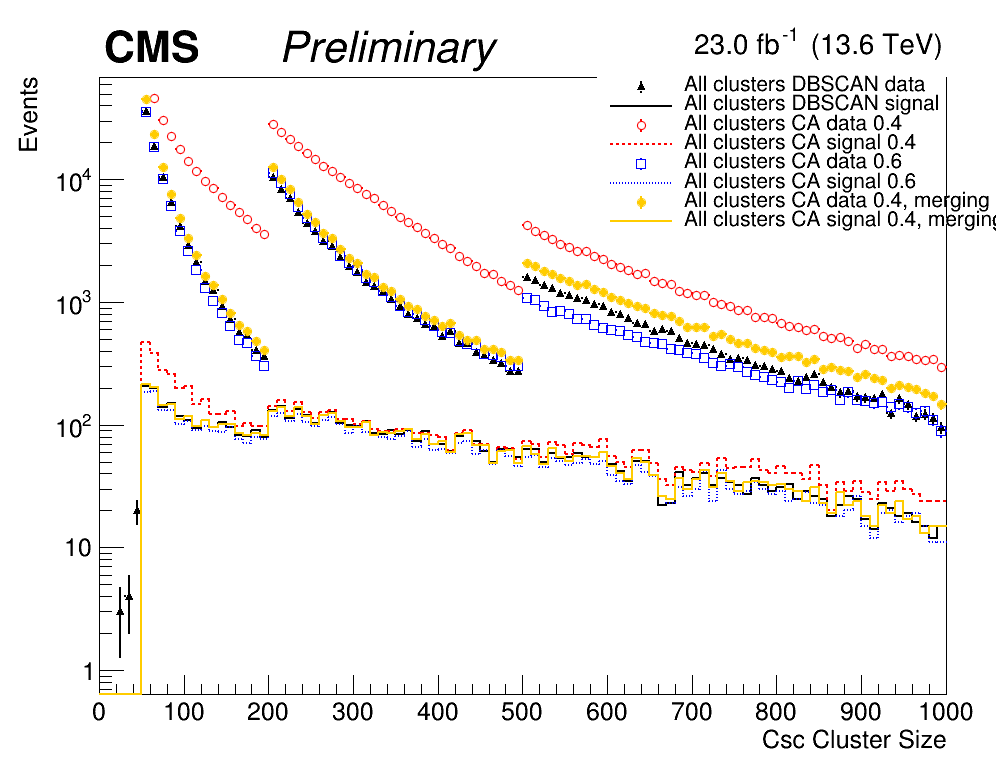

In [119]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.6,0.7,0.95,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:

        
    tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] ]    
    h0[k] = create_TH1D(tmp_cscClusterSize[:,:].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h0[k],"All clusters "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(colors[k])
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(colors[k])
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

        
    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    #h2[k].Draw('PE same')
    
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscClusterSize_all"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscClusterSize_all"+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

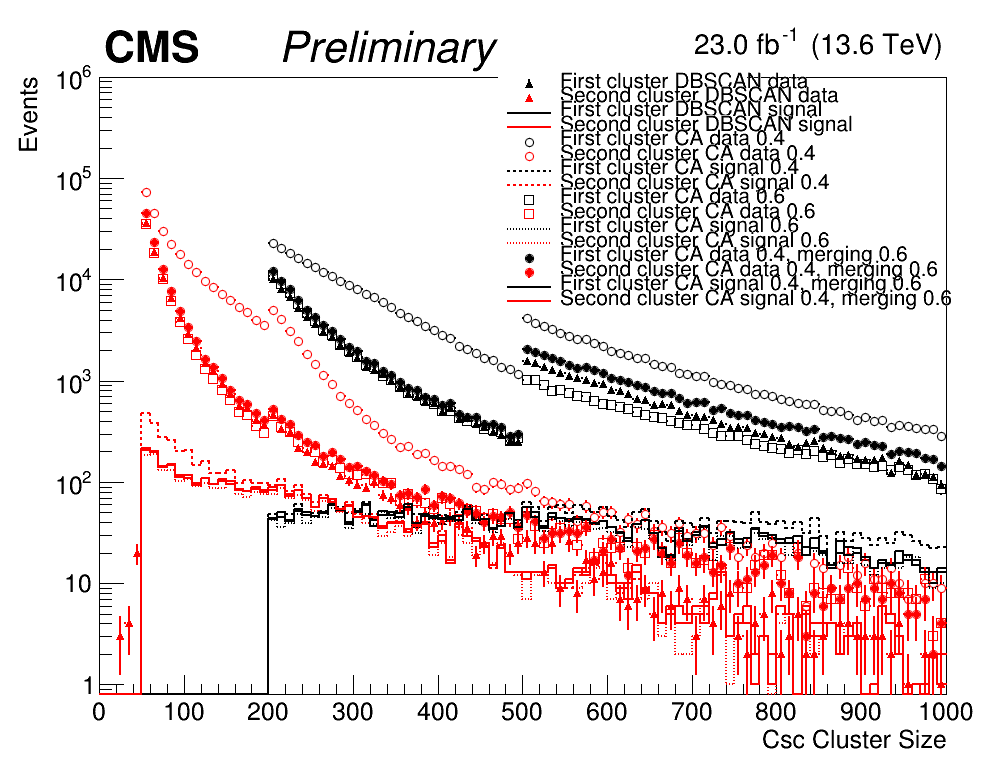

In [120]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:

        
    tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] ]    
    h0[k] = create_TH1D(tmp_cscClusterSize[:,0].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h0[k],"First cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(1)
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(1)
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    tmp_cscClusterSize = cscClusterSize[k][ np.logical_and(event_cut[k],nCscClusters[k]>1) ]
    h1[k] = create_TH1D(tmp_cscClusterSize[:,1].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h1[k],"Second cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h1[k].SetLineColor(2)
    h1[k].SetLineWidth(2)
    h1[k].SetLineStyle(line_style[k])
    h1[k].SetMarkerColor(2)
    h1[k].SetMarkerStyle(marker_style[k])
    h1[k].SetMarkerSize(1.2)
    #if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    
    #selection when more than 2...
    #h2[k] = create_TH1D(cscClusterSize3[k][:,2].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    #leg.AddEntry(h2[k],"Third cluster "+data_label[k],'PE' if 'data' in k else 'L')
    #h2[k].SetLineColor(4)
    #h2[k].SetLineWidth(2)
    #h2[k].SetLineStyle(line_style[k])
    #h2[k].SetMarkerColor(4)
    #h2[k].SetMarkerStyle(marker_style[k])
    #h2[k].SetMarkerSize(1.2)    
    #if h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())
        
    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
    #h2[k].Draw('PE same')
    h0[k].SetMinimum(0.8)
    h0[k].SetMaximum(1.e6)
    
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscClusterSize"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscClusterSize"+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

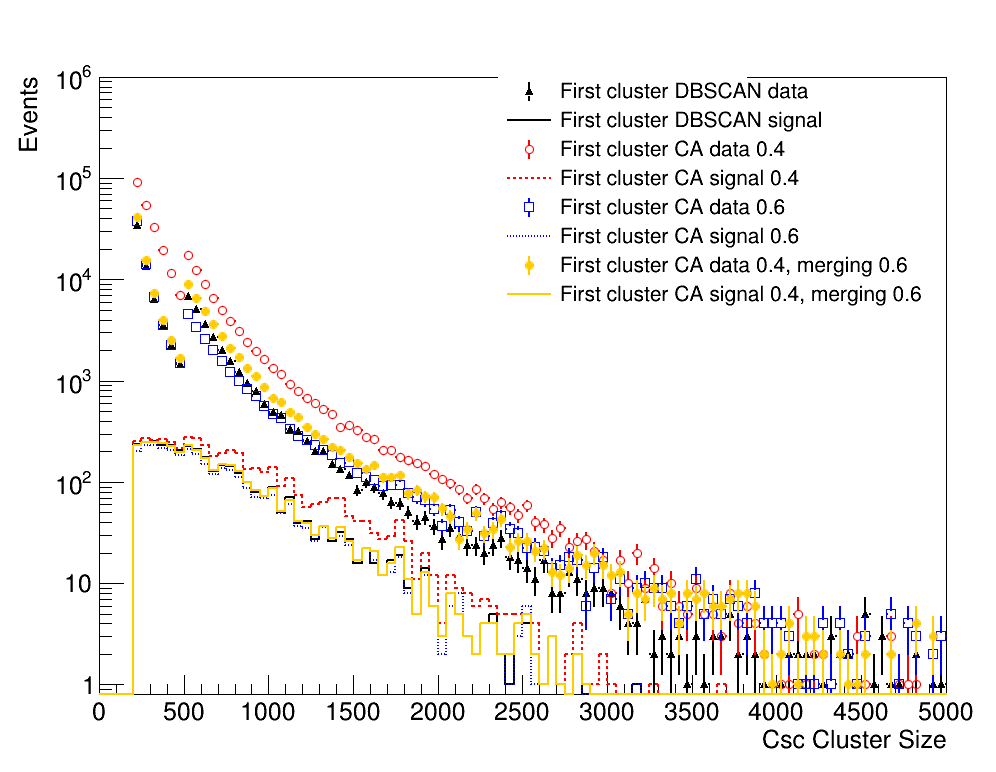

In [121]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:
    tmp_cscClusterSize = cscClusterSize[k][ event_cut[k] ]
    h0[k] = create_TH1D(tmp_cscClusterSize[:,0].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,5000])
    leg.AddEntry(h0[k],"First cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(colors[k])
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(colors[k])
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h0[k].SetMinimum(0.8)
    h0[k].SetMaximum(1.e6)
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterSize"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterSize"+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

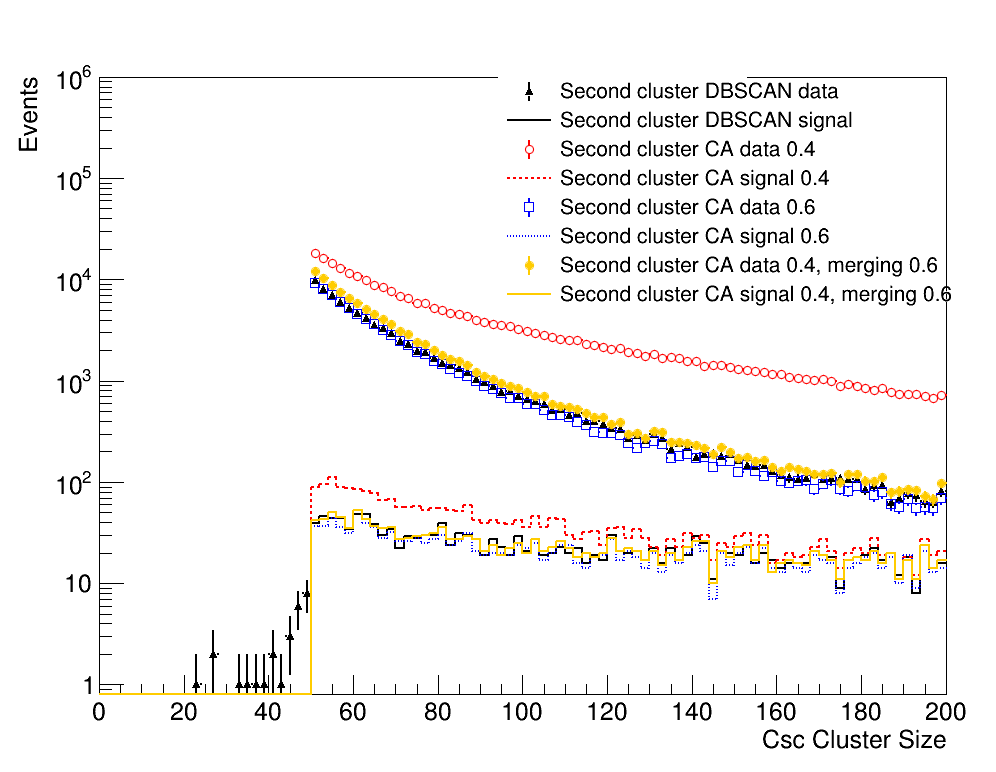

In [122]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:
    tmp_cscClusterSize = cscClusterSize[k][ np.logical_and(event_cut[k],nCscClusters[k]>1) ]
    h0[k] = create_TH1D(tmp_cscClusterSize[:,1].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,200])
    leg.AddEntry(h0[k],"Second cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(colors[k])
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(colors[k])
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h0[k].SetMinimum(0.8)
    h0[k].SetMaximum(1.e6)
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscSecondClusterSize"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscSecondClusterSize"+plot_string+".png")

### Clusters in different HLT categories

* First cluster fires L1 (200 hits)
* First cluster fires OR of triggers
* First cluster fires each specific HLT region

TODO

In [123]:
first_fired_L1 = {}
first_fired_HLT = {} 
first_fired_HLT_tr1 = {}
first_fired_HLT_tr2 = {}
first_fired_HLT_tr3 = {}
cscClusterSize_0_HLT = {}
cscClusterSize_0_HLT_tr1 = {}
cscClusterSize_0_HLT_tr2 = {}
cscClusterSize_0_HLT_tr3 = {}
cscClusterSize_1_HLT = {}
cscClusterSize_1_HLT_tr1 = {}
cscClusterSize_1_HLT_tr2 = {}
cscClusterSize_1_HLT_tr3 = {}


cscClusterAvgStation_0_HLT = {}
cscClusterAvgStation_0_HLT_tr1 = {}
cscClusterAvgStation_0_HLT_tr2 = {}
cscClusterAvgStation_0_HLT_tr3 = {}

cscClusterAvgStation_1_HLT = {}
cscClusterAvgStation_1_HLT_tr1 = {}
cscClusterAvgStation_1_HLT_tr2 = {}
cscClusterAvgStation_1_HLT_tr3 = {}

cscClusterMaxStation_0_HLT = {}
cscClusterMaxStation_0_HLT_tr1 = {}
cscClusterMaxStation_0_HLT_tr2 = {}
cscClusterMaxStation_0_HLT_tr3 = {}

cscClusterMaxStation_1_HLT = {}
cscClusterMaxStation_1_HLT_tr1 = {}
cscClusterMaxStation_1_HLT_tr2 = {}
cscClusterMaxStation_1_HLT_tr3 = {}


cscClusterMaxChamber_0_HLT = {}
cscClusterMaxChamber_0_HLT_tr1 = {}
cscClusterMaxChamber_0_HLT_tr2 = {}
cscClusterMaxChamber_0_HLT_tr3 = {}

cscClusterMaxChamber_1_HLT = {}
cscClusterMaxChamber_1_HLT_tr1 = {}
cscClusterMaxChamber_1_HLT_tr2 = {}
cscClusterMaxChamber_1_HLT_tr3 = {}

for k in tree_keys:    
    print(k)
    sub_sel = np.logical_and(event_cut[k],nCscClusters[k]==2)
    first_fired_L1[k] = cscClusterSize[k][ sub_sel ][:,0]>=200
    first_fired_HLT[k] = np.logical_and(sel_HLT_OR[k][ sub_sel ][:,0]>0,first_fired_L1[k])
    first_fired_HLT_tr1[k] = np.logical_and(sel_trgCluster_tr1[k][ sub_sel ][:,0]>0,first_fired_L1[k])
    first_fired_HLT_tr2[k] = np.logical_and(sel_trgCluster_tr2[k][ sub_sel ][:,0]>0,first_fired_L1[k])
    first_fired_HLT_tr3[k] = np.logical_and(sel_trgCluster_tr3[k][ sub_sel ][:,0]>0,first_fired_L1[k])
    

    cscClusterSize_0_HLT[k] = cscClusterSize[k][sub_sel][first_fired_HLT[k]][:,0]
    cscClusterSize_0_HLT_tr1[k] = cscClusterSize[k][sub_sel][first_fired_HLT_tr1[k]][:,0]
    cscClusterSize_0_HLT_tr2[k] = cscClusterSize[k][sub_sel][first_fired_HLT_tr2[k]][:,0]
    cscClusterSize_0_HLT_tr3[k] = cscClusterSize[k][sub_sel][first_fired_HLT_tr3[k]][:,0]
    cscClusterSize_1_HLT[k] = cscClusterSize[k][sub_sel][first_fired_HLT[k]][:,1]
    cscClusterSize_1_HLT_tr1[k] = cscClusterSize[k][sub_sel][first_fired_HLT_tr1[k]][:,1]
    cscClusterSize_1_HLT_tr2[k] = cscClusterSize[k][sub_sel][first_fired_HLT_tr2[k]][:,1]
    cscClusterSize_1_HLT_tr3[k] = cscClusterSize[k][sub_sel][first_fired_HLT_tr3[k]][:,1]
    
    
    cscClusterAvgStation_0_HLT[k] = cscClusterAvgStation[k][sub_sel][first_fired_HLT[k]][:,0]
    cscClusterAvgStation_0_HLT_tr1[k] = cscClusterAvgStation[k][sub_sel][first_fired_HLT_tr1[k]][:,0]
    cscClusterAvgStation_0_HLT_tr2[k] = cscClusterAvgStation[k][sub_sel][first_fired_HLT_tr2[k]][:,0]
    cscClusterAvgStation_0_HLT_tr3[k] = cscClusterAvgStation[k][sub_sel][first_fired_HLT_tr3[k]][:,0]
    cscClusterAvgStation_1_HLT[k] = cscClusterAvgStation[k][sub_sel][first_fired_HLT[k]][:,1]
    cscClusterAvgStation_1_HLT_tr1[k] = cscClusterAvgStation[k][sub_sel][first_fired_HLT_tr1[k]][:,1]
    cscClusterAvgStation_1_HLT_tr2[k] = cscClusterAvgStation[k][sub_sel][first_fired_HLT_tr2[k]][:,1]
    cscClusterAvgStation_1_HLT_tr3[k] = cscClusterAvgStation[k][sub_sel][first_fired_HLT_tr3[k]][:,1]
    
    cscClusterMaxStation_0_HLT[k] = cscClusterMaxStation[k][sub_sel][first_fired_HLT[k]][:,0]
    cscClusterMaxStation_0_HLT_tr1[k] = cscClusterMaxStation[k][sub_sel][first_fired_HLT_tr1[k]][:,0]
    cscClusterMaxStation_0_HLT_tr2[k] = cscClusterMaxStation[k][sub_sel][first_fired_HLT_tr2[k]][:,0]
    cscClusterMaxStation_0_HLT_tr3[k] = cscClusterMaxStation[k][sub_sel][first_fired_HLT_tr3[k]][:,0]
    cscClusterMaxStation_1_HLT[k] = cscClusterMaxStation[k][sub_sel][first_fired_HLT[k]][:,1]
    cscClusterMaxStation_1_HLT_tr1[k] = cscClusterMaxStation[k][sub_sel][first_fired_HLT_tr1[k]][:,1]
    cscClusterMaxStation_1_HLT_tr2[k] = cscClusterMaxStation[k][sub_sel][first_fired_HLT_tr2[k]][:,1]
    cscClusterMaxStation_1_HLT_tr3[k] = cscClusterMaxStation[k][sub_sel][first_fired_HLT_tr3[k]][:,1]
    
    cscClusterMaxChamber_0_HLT[k] = cscClusterMaxChamber[k][sub_sel][first_fired_HLT[k]][:,0]
    cscClusterMaxChamber_0_HLT_tr1[k] = cscClusterMaxChamber[k][sub_sel][first_fired_HLT_tr1[k]][:,0]
    cscClusterMaxChamber_0_HLT_tr2[k] = cscClusterMaxChamber[k][sub_sel][first_fired_HLT_tr2[k]][:,0]
    cscClusterMaxChamber_0_HLT_tr3[k] = cscClusterMaxChamber[k][sub_sel][first_fired_HLT_tr3[k]][:,0]
    cscClusterMaxChamber_1_HLT[k] = cscClusterMaxChamber[k][sub_sel][first_fired_HLT[k]][:,1]
    cscClusterMaxChamber_1_HLT_tr1[k] = cscClusterMaxChamber[k][sub_sel][first_fired_HLT_tr1[k]][:,1]
    cscClusterMaxChamber_1_HLT_tr2[k] = cscClusterMaxChamber[k][sub_sel][first_fired_HLT_tr2[k]][:,1]
    cscClusterMaxChamber_1_HLT_tr3[k] = cscClusterMaxChamber[k][sub_sel][first_fired_HLT_tr3[k]][:,1]


datav4
signalv4
datav5
signalv5
datav6
signalv6
datav10
signalv10


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potenti

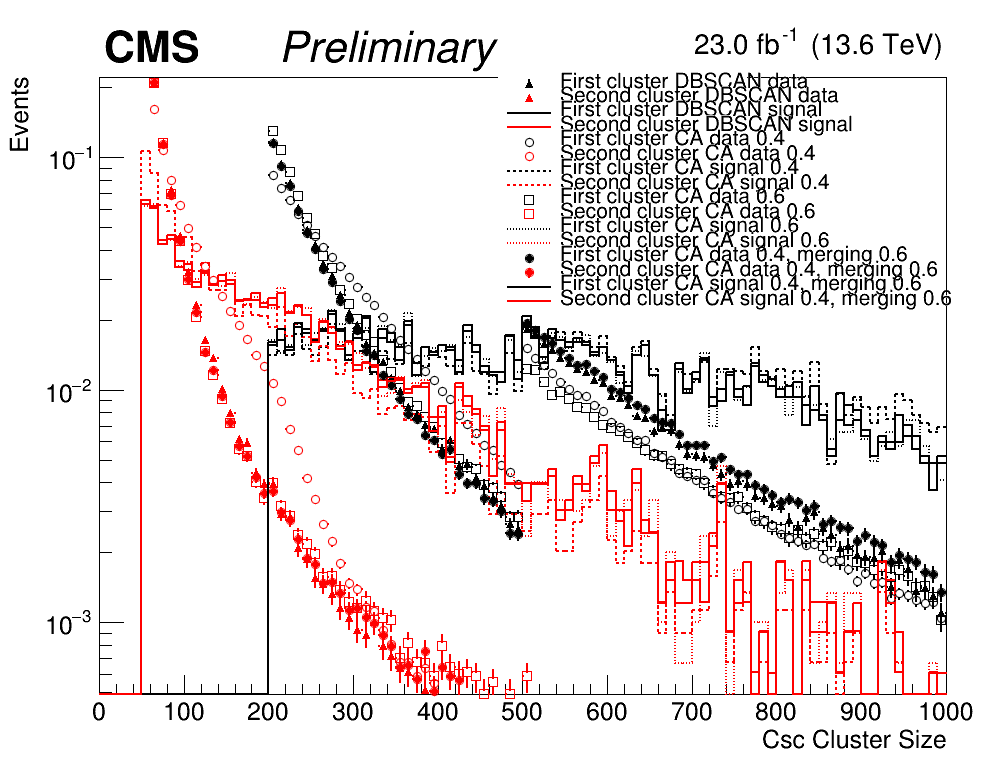

In [124]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:

        
    tmp_cscClusterSize = cscClusterSize_0_HLT[k]    
    h0[k] = create_TH1D(tmp_cscClusterSize.flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h0[k],"First cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(1)
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(1)
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    tmp_cscClusterSize = cscClusterSize_1_HLT[k]
    h1[k] = create_TH1D(tmp_cscClusterSize.flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h1[k],"Second cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h1[k].SetLineColor(2)
    h1[k].SetLineWidth(2)
    h1[k].SetLineStyle(line_style[k])
    h1[k].SetMarkerColor(2)
    h1[k].SetMarkerStyle(marker_style[k])
    h1[k].SetMarkerSize(1.2)
    if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    
    #selection when more than 2...
    #h2[k] = create_TH1D(cscClusterSize3[k][:,2].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    #leg.AddEntry(h2[k],"Third cluster "+data_label[k],'PE' if 'data' in k else 'L')
    #h2[k].SetLineColor(4)
    #h2[k].SetLineWidth(2)
    #h2[k].SetLineStyle(line_style[k])
    #h2[k].SetMarkerColor(4)
    #h2[k].SetMarkerStyle(marker_style[k])
    #h2[k].SetMarkerSize(1.2)    
    #if h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())
        
    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
    #h2[k].Draw('PE same')
    
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscClusterSize_first_fires_HLT"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscClusterSize_first_fires_HLT"+plot_string+".png")

### First/second cluster in different HLT categories

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

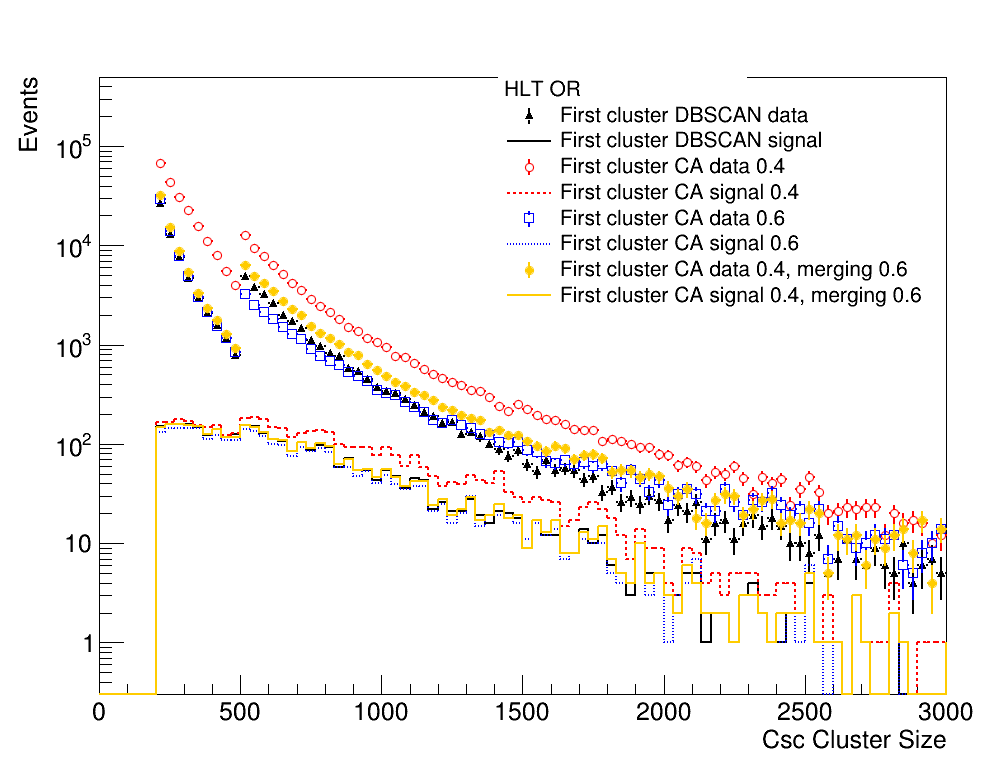

In [125]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

h0 = {}
h1 = {}
h2 = {}


cat_lab = "HLT_OR"
#cat_lab = "HLT_1"
#cat_lab = "HLT_2"
#cat_lab = "HLT_3"


cat_lab_dict = {}
cat_lab_dict["HLT_OR"] = "HLT OR"
cat_lab_dict["HLT_1"] = "HLT |#eta|<1.9, #geq 2 stations, 100 hits"
cat_lab_dict["HLT_2"] = "HLT |#eta|<1.9, 1 station, 200 hits"
cat_lab_dict["HLT_3"] = "HLT |#eta| #leq 1.9, 500 hits"
leg.SetHeader(cat_lab_dict[cat_lab])
can.cd()
for k in tree_keys:
    if cat_lab=="HLT_OR":
        tmp_cscClusterSize = cscClusterSize_0_HLT[k] 
    elif cat_lab=="HLT_1":
        tmp_cscClusterSize = cscClusterSize_0_HLT_tr1[k]
    elif cat_lab=="HLT_2":
        tmp_cscClusterSize = cscClusterSize_0_HLT_tr2[k] 
    elif cat_lab=="HLT_3":
        tmp_cscClusterSize = cscClusterSize_0_HLT_tr3[k] 
    h0[k] = create_TH1D(tmp_cscClusterSize.flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[90,0,3000])
    leg.AddEntry(h0[k],"First cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(colors[k])
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(colors[k])
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h0[k].SetMaximum(5.e5)
    h0[k].SetMinimum(0.3)
    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterSize_first_fires_"+cat_lab.replace(" ","_")+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterSize_first_fires_"+cat_lab.replace(" ","_")+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

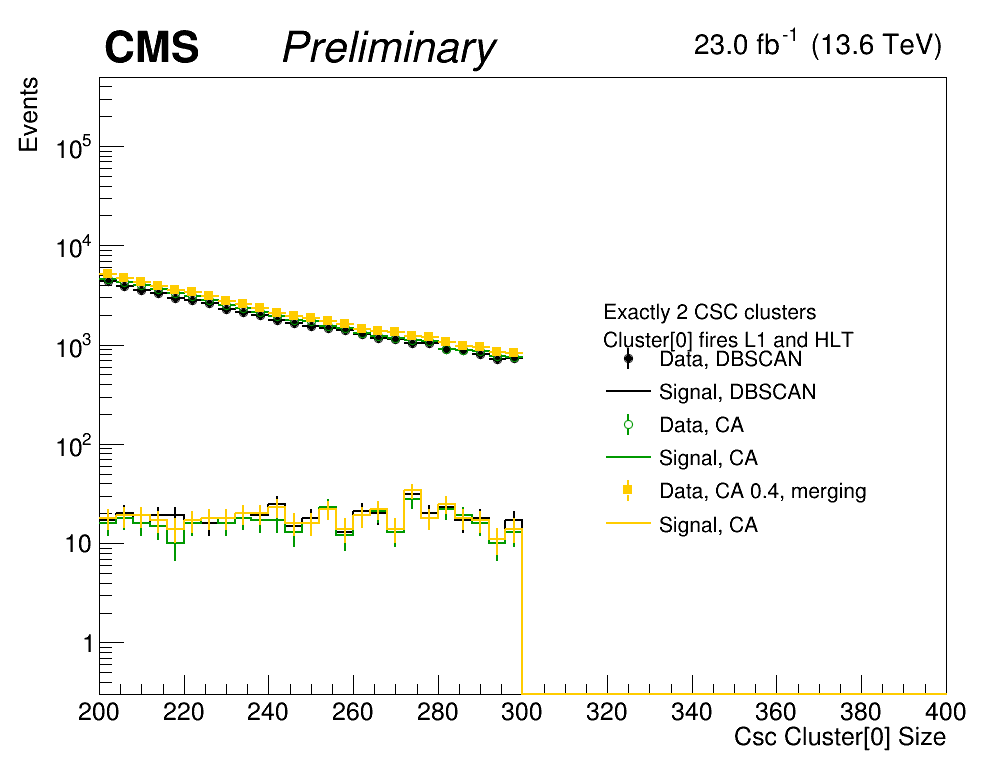

In [126]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.6,0.3,0.85,0.6)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

h0 = {}
h1 = {}
h2 = {}


cat_lab = "HLT_OR"
#cat_lab = "HLT_1"
#cat_lab = "HLT_2"
#cat_lab = "HLT_3"

data_label_tmp = {}
marker_style_tmp = {}
line_style_tmp = {}
colors_tmp = {}
data_label_tmp['datav4'] = 'Data, DBSCAN'
data_label_tmp['datav5'] = 'CA data 0.4'
data_label_tmp['datav6'] = 'Data, CA'
data_label_tmp['datav10'] = 'Data, CA 0.4, merging'

data_label_tmp['signalv4'] = 'Signal, DBSCAN'
data_label_tmp['signalv5'] = 'CA signal 0.4'
data_label_tmp['signalv6'] = 'Signal, CA'
data_label_tmp['signalv10'] = 'Signal, CA'

marker_style_tmp['datav4'] = 20
marker_style_tmp['datav5'] = 24
marker_style_tmp['datav6'] = 24
marker_style_tmp['datav10'] = 21

marker_style_tmp['signalv4'] = 25
marker_style_tmp['signalv5'] = 20
marker_style_tmp['signalv6'] = 26
marker_style_tmp['signalv10'] = 27

line_style_tmp['datav4'] = 1
line_style_tmp['datav5'] = 1
line_style_tmp['datav6'] = 1
line_style_tmp['datav10'] = 1

line_style_tmp['signalv4'] = 1
line_style_tmp['signalv5'] = 2
line_style_tmp['signalv6'] = 1
line_style_tmp['signalv10'] = 1

colors_tmp['datav4'] = 1
colors_tmp['datav5'] = 2
colors_tmp['datav6'] = 418
colors_tmp['datav10'] = 800

colors_tmp['signalv4'] = 1#4
colors_tmp['signalv5'] = 2#8
colors_tmp['signalv6'] = 418#2
colors_tmp['signalv10'] = 800#7

cat_lab_dict = {}
cat_lab_dict["HLT_OR"] = "HLT OR"
cat_lab_dict["HLT_1"] = "HLT |#eta|<1.9, #geq 2 stations, 100 hits"
cat_lab_dict["HLT_2"] = "HLT |#eta|<1.9, 1 station, 200 hits"
cat_lab_dict["HLT_3"] = "HLT |#eta| #leq 1.9, 500 hits"
leg.SetHeader("#splitline{Exactly 2 CSC clusters}{Cluster[0] fires L1 and HLT}")
can.cd()
for k in tree_keys:
    if 'v5' in k: continue
    if cat_lab=="HLT_OR":
        tmp_cscClusterSize = cscClusterSize_0_HLT[k][cscClusterSize_0_HLT[k]<300]
    elif cat_lab=="HLT_1":
        tmp_cscClusterSize = cscClusterSize_0_HLT_tr1[k]
    elif cat_lab=="HLT_2":
        tmp_cscClusterSize = cscClusterSize_0_HLT_tr2[k] 
    elif cat_lab=="HLT_3":
        tmp_cscClusterSize = cscClusterSize_0_HLT_tr3[k] 
    h0[k] = create_TH1D(tmp_cscClusterSize.flatten(),title="",axis_title = ['Csc Cluster[0] Size','Events'], binning=[50,200,400])
    leg.AddEntry(h0[k],""+data_label_tmp[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(colors_tmp[k])
    #h0[k].SetFillColor(colors_tmp[k])
    #h0[k].SetFillStyle(0 if 'data' in k else 8001)
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style_tmp[k])
    h0[k].SetMarkerColor(colors_tmp[k])
    h0[k].SetMarkerStyle(marker_style_tmp[k])
    h0[k].SetMarkerSize(1.2 if 'data' in k else 0)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h0[k].SetMaximum(5.e5)
    h0[k].SetMinimum(0.3)
    h0[k].Draw('PE same' if 'data' in k else 'HISTO E0 same')
    
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterSize_200_300_first_fires_"+cat_lab.replace(" ","_")+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterSize_200_300_first_fires_"+cat_lab.replace(" ","_")+plot_string+".png")

datav4
signalv4
datav5
signalv5
datav6
signalv6
datav10
signalv10


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

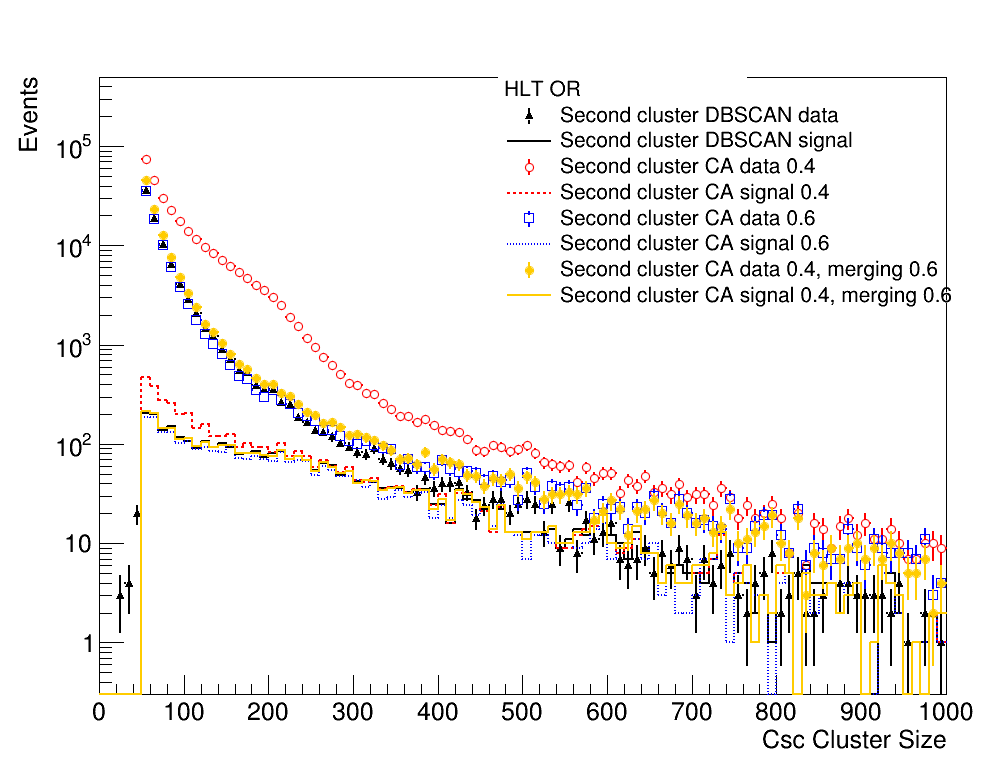

In [127]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

h0 = {}
h1 = {}
h2 = {}


leg.SetHeader(cat_lab_dict[cat_lab])
can.cd()
for k in tree_keys:
    print(k)
    if cat_lab=="HLT_OR":
        tmp_cscClusterSize = cscClusterSize_1_HLT[k] 
    elif cat_lab=="HLT_1":
        tmp_cscClusterSize = cscClusterSize_1_HLT_tr1[k]
    elif cat_lab=="HLT_2":
        tmp_cscClusterSize = cscClusterSize_1_HLT_tr2[k] 
    elif cat_lab=="HLT_3":
        tmp_cscClusterSize = cscClusterSize_1_HLT_tr3[k] 
    h0[k] = create_TH1D(tmp_cscClusterSize.flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h0[k],"Second cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(colors[k])
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(colors[k])
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    
    h0[k].SetMaximum(5.e5)
    h0[k].SetMinimum(0.3)

    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscSecondClusterSize_first_fires_"+cat_lab.replace(" ","_")+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscSecondClusterSize_first_fires_"+cat_lab.replace(" ","_")+plot_string+".png")

### Look at the station

TODO

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

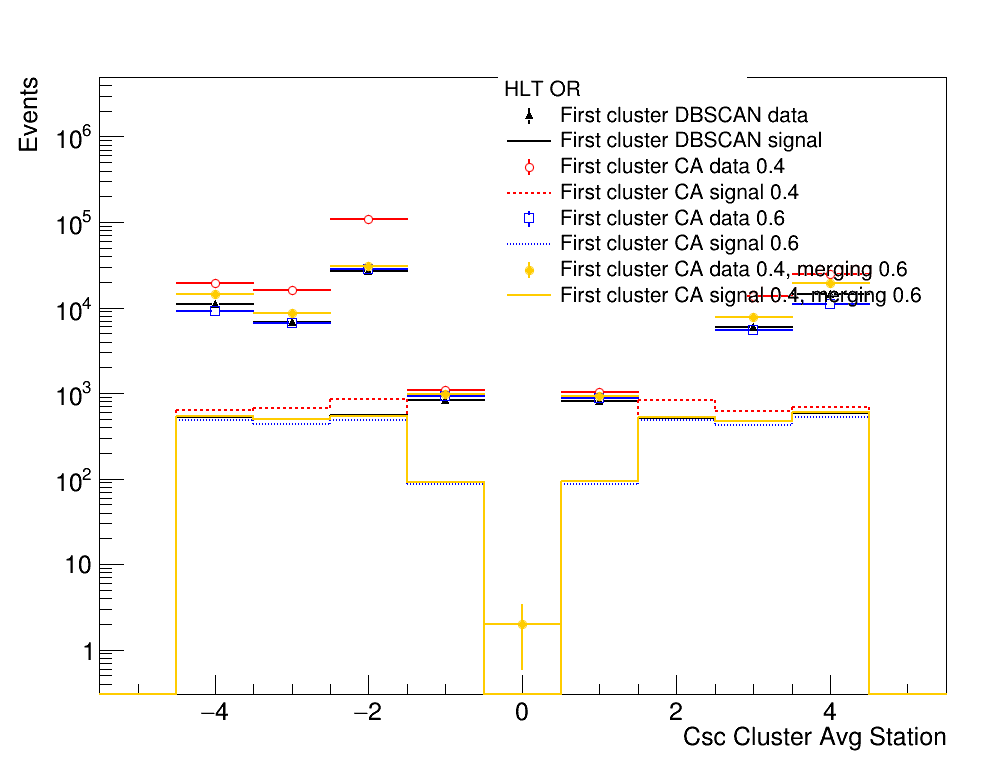

In [128]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

h0 = {}
h1 = {}
h2 = {}


leg.SetHeader(cat_lab_dict[cat_lab])
can.cd()
for k in tree_keys:
    if cat_lab=="HLT_OR":
        tmp_var = cscClusterAvgStation_0_HLT[k] 
    elif cat_lab=="HLT_1":
        tmp_var = cscClusterAvgStation_0_HLT_tr1[k]
    elif cat_lab=="HLT_2":
        tmp_var = cscClusterAvgStation_0_HLT_tr2[k] 
    elif cat_lab=="HLT_3":
        tmp_var = cscClusterAvgStation_0_HLT_tr3[k] 
    h0[k] = create_TH1D(tmp_var.flatten(),title="",axis_title = ['Csc Cluster Avg Station','Events'], binning=[11,-5-0.5,6-0.5])
    leg.AddEntry(h0[k],"First cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(colors[k])
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(colors[k])
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h0[k].SetMaximum(5.e6)
    h0[k].SetMinimum(0.3)
    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterAvgStation_first_fires_"+cat_lab.replace(" ","_")+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterAvgStation_first_fires_"+cat_lab.replace(" ","_")+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

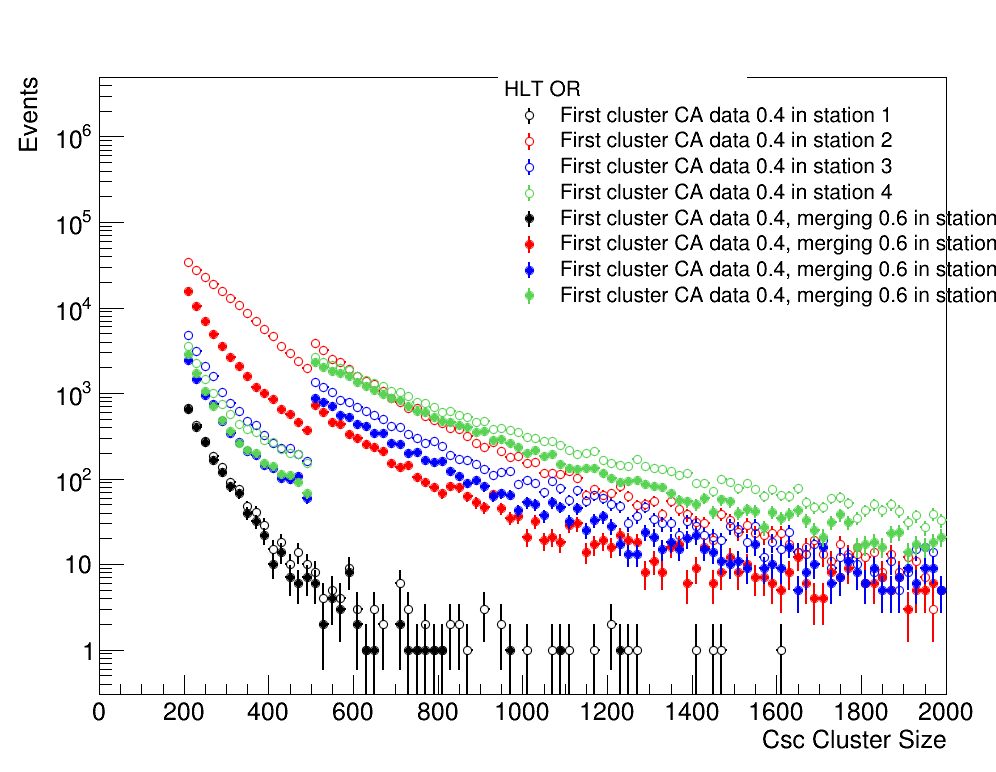

In [129]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

h0 = {}
h1 = {}
h2 = {}
h3 = {}
h4 = {}

leg.SetHeader(cat_lab_dict[cat_lab])
can.cd()
for k in tree_keys:
    if "signal" in k: continue
    if "v4" in k: continue
    if "v6" in k: continue
    if cat_lab=="HLT_OR":
        tmp_sel = cscClusterMaxStation_0_HLT[k]
        tmp_var = cscClusterSize_0_HLT[k]
    elif cat_lab=="HLT_1":
        tmp_sel = cscClusterMaxStation_0_HLT_tr1[k]
        tmp_var = cscClusterSize_0_HLT_tr1[k]
    elif cat_lab=="HLT_2":
        tmp_sel = cscClusterMaxStation_0_HLT_tr2[k] 
        tmp_var = cscClusterSize_0_HLT_tr2[k]
    elif cat_lab=="HLT_3":
        tmp_sel = cscClusterMaxStation_0_HLT_tr3[k] 
        tmp_var = cscClusterSize_0_HLT_tr3[k]
        
    h1[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==1].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,2000])
    leg.AddEntry(h1[k],"First cluster "+data_label[k]+" in station 1",'PE' if 'data' in k else 'L')
    h1[k].SetLineColor(1)#(colors[k])
    h1[k].SetLineWidth(2)
    h1[k].SetLineStyle(line_style[k])
    h1[k].SetMarkerColor(1)#(colors[k])
    h1[k].SetMarkerStyle(marker_style[k])
    h1[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h1[k].SetMaximum(5.e6)
    h1[k].SetMinimum(0.3)
    h1[k].Draw('PE same' if 'data' in k else 'HISTO same')

    h2[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==2].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,2000])
    leg.AddEntry(h2[k],"First cluster "+data_label[k]+" in station 2",'PE' if 'data' in k else 'L')
    h2[k].SetLineColor(2)#(colors[k])
    h2[k].SetLineWidth(2)
    h2[k].SetLineStyle(line_style[k])
    h2[k].SetMarkerColor(2)#(colors[k])
    h2[k].SetMarkerStyle(marker_style[k])
    h2[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h2[k].SetMaximum(5.e6)
    h2[k].SetMinimum(0.3)
    h2[k].Draw('PE same' if 'data' in k else 'HISTO same')    

    h3[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==3].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,2000])
    leg.AddEntry(h3[k],"First cluster "+data_label[k]+" in station 3",'PE' if 'data' in k else 'L')
    h3[k].SetLineColor(4)#(colors[k])
    h3[k].SetLineWidth(2)
    h3[k].SetLineStyle(line_style[k])
    h3[k].SetMarkerColor(4)#(colors[k])
    h3[k].SetMarkerStyle(marker_style[k])
    h3[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h3[k].SetMaximum(5.e6)
    h3[k].SetMinimum(0.3)
    h3[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
    
    h4[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==4].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,2000])
    leg.AddEntry(h4[k],"First cluster "+data_label[k]+" in station 4",'PE' if 'data' in k else 'L')
    h4[k].SetLineColor(8)#(colors[k])
    h4[k].SetLineWidth(2)
    h4[k].SetLineStyle(line_style[k])
    h4[k].SetMarkerColor(8)#(colors[k])
    h4[k].SetMarkerStyle(marker_style[k])
    h4[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h4[k].SetMaximum(5.e6)
    h4[k].SetMinimum(0.3)
    h4[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterSize_per_station_first_fires_"+cat_lab.replace(" ","_")+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterSize_per_station_first_fires_"+cat_lab.replace(" ","_")+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

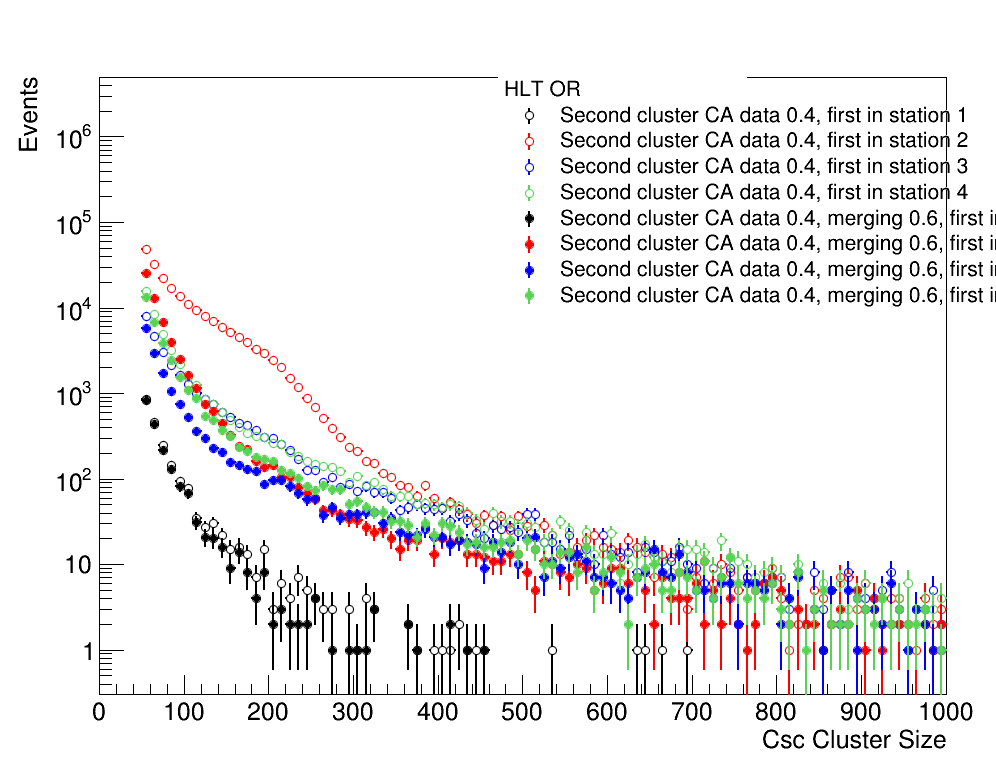

In [130]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

h0 = {}
h1 = {}
h2 = {}
h3 = {}
h4 = {}

leg.SetHeader(cat_lab_dict[cat_lab])
can.cd()
for k in tree_keys:
    if "signal" in k: continue
    if "v4" in k: continue
    if "v6" in k: continue
    if cat_lab=="HLT_OR":
        tmp_sel = cscClusterMaxStation_0_HLT[k]
        tmp_var = cscClusterSize_1_HLT[k]
    elif cat_lab=="HLT_1":
        tmp_sel = cscClusterMaxStation_0_HLT_tr1[k]
        tmp_var = cscClusterSize_1_HLT_tr1[k]
    elif cat_lab=="HLT_2":
        tmp_sel = cscClusterMaxStation_0_HLT_tr2[k] 
        tmp_var = cscClusterSize_1_HLT_tr2[k]
    elif cat_lab=="HLT_3":
        tmp_sel = cscClusterMaxStation_0_HLT_tr3[k] 
        tmp_var = cscClusterSize_1_HLT_tr3[k]
        
    h1[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==1].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h1[k],"Second cluster "+data_label[k]+", first in station 1",'PE' if 'data' in k else 'L')
    h1[k].SetLineColor(1)#(colors[k])
    h1[k].SetLineWidth(2)
    h1[k].SetLineStyle(line_style[k])
    h1[k].SetMarkerColor(1)#(colors[k])
    h1[k].SetMarkerStyle(marker_style[k])
    h1[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h1[k].SetMaximum(5.e6)
    h1[k].SetMinimum(0.3)
    h1[k].Draw('PE same' if 'data' in k else 'HISTO same')

    h2[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==2].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h2[k],"Second cluster "+data_label[k]+", first in station 2",'PE' if 'data' in k else 'L')
    h2[k].SetLineColor(2)#(colors[k])
    h2[k].SetLineWidth(2)
    h2[k].SetLineStyle(line_style[k])
    h2[k].SetMarkerColor(2)#(colors[k])
    h2[k].SetMarkerStyle(marker_style[k])
    h2[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h2[k].SetMaximum(5.e6)
    h2[k].SetMinimum(0.3)
    h2[k].Draw('PE same' if 'data' in k else 'HISTO same')    

    h3[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==3].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h3[k],"Second cluster "+data_label[k]+", first in station 3",'PE' if 'data' in k else 'L')
    h3[k].SetLineColor(4)#(colors[k])
    h3[k].SetLineWidth(2)
    h3[k].SetLineStyle(line_style[k])
    h3[k].SetMarkerColor(4)#(colors[k])
    h3[k].SetMarkerStyle(marker_style[k])
    h3[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h3[k].SetMaximum(5.e6)
    h3[k].SetMinimum(0.3)
    h3[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
    
    h4[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==4].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    leg.AddEntry(h4[k],"Second cluster "+data_label[k]+", first in station 4",'PE' if 'data' in k else 'L')
    h4[k].SetLineColor(8)#(colors[k])
    h4[k].SetLineWidth(2)
    h4[k].SetLineStyle(line_style[k])
    h4[k].SetMarkerColor(8)#(colors[k])
    h4[k].SetMarkerStyle(marker_style[k])
    h4[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h4[k].SetMaximum(5.e6)
    h4[k].SetMinimum(0.3)
    h4[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscSecondClusterSize_per_station_first_fires_"+cat_lab.replace(" ","_")+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscSecondClusterSize_per_station_first_fires_"+cat_lab.replace(" ","_")+plot_string+".png")

[-1073741824           0 -2147483648 ...  -536870912 -1073741824
           0]
[2 3 2 ... 2 2 2]


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

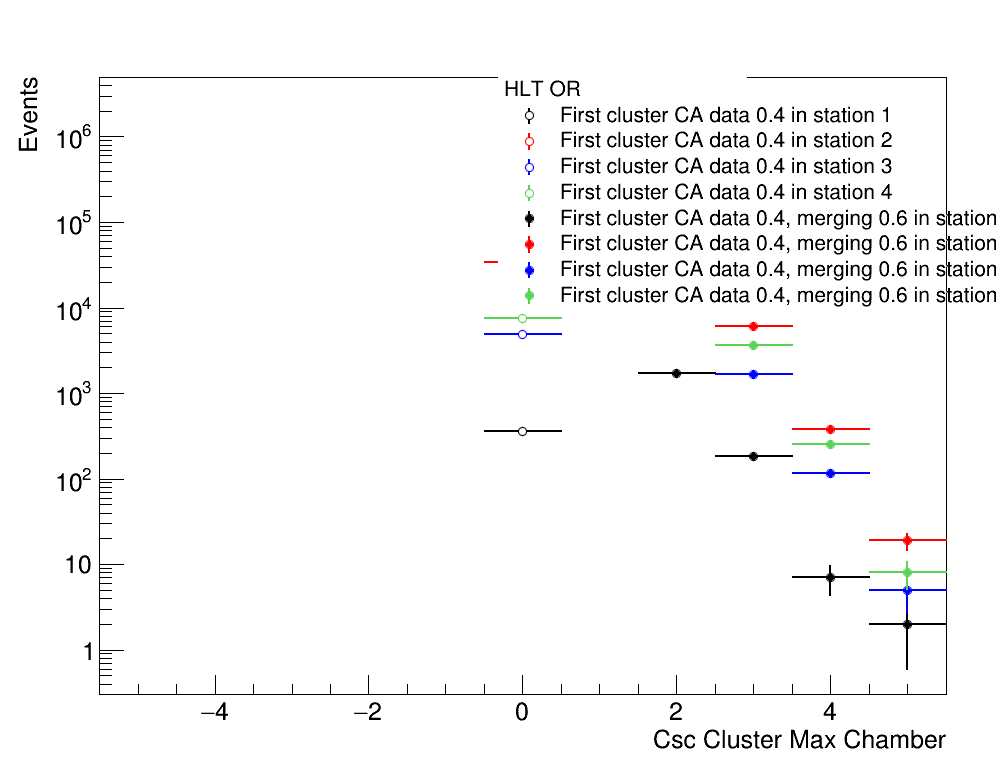

In [131]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.9)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

h0 = {}
h1 = {}
h2 = {}
h3 = {}
h4 = {}

leg.SetHeader(cat_lab_dict[cat_lab])
can.cd()
for k in tree_keys:
    if "signal" in k: continue
    if "v4" in k: continue
    if "v6" in k: continue
    if cat_lab=="HLT_OR":
        tmp_sel = cscClusterMaxStation_0_HLT[k]
        tmp_var = cscClusterMaxChamber_0_HLT[k]
    elif cat_lab=="HLT_1":
        tmp_sel = cscClusterMaxStation_0_HLT_tr1[k]
        tmp_var = cscClusterMaxChamber_0_HLT_tr1[k]
    elif cat_lab=="HLT_2":
        tmp_sel = cscClusterMaxStation_0_HLT_tr2[k] 
        tmp_var = cscClusterMaxChamber_0_HLT_tr2[k]
    elif cat_lab=="HLT_3":
        tmp_sel = cscClusterMaxStation_0_HLT_tr3[k] 
        tmp_var = cscClusterMaxChamber_0_HLT_tr3[k]
        
    print(tmp_var[np.abs(tmp_sel)==1])
        
    h1[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==1].flatten(),title="",axis_title = ['Csc Cluster Max Chamber','Events'], binning=[11,-5-0.5,6-0.5])
    leg.AddEntry(h1[k],"First cluster "+data_label[k]+" in station 1",'PE' if 'data' in k else 'L')
    h1[k].SetLineColor(1)#(colors[k])
    h1[k].SetLineWidth(2)
    h1[k].SetLineStyle(line_style[k])
    h1[k].SetMarkerColor(1)#(colors[k])
    h1[k].SetMarkerStyle(marker_style[k])
    h1[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h1[k].SetMaximum(5.e6)
    h1[k].SetMinimum(0.3)
    h1[k].Draw('PE same' if 'data' in k else 'HISTO same')

    h2[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==2].flatten(),title="",axis_title = ['Csc Cluster Max Chamber','Events'], binning=[11,-5-0.5,6-0.5])
    leg.AddEntry(h2[k],"First cluster "+data_label[k]+" in station 2",'PE' if 'data' in k else 'L')
    h2[k].SetLineColor(2)#(colors[k])
    h2[k].SetLineWidth(2)
    h2[k].SetLineStyle(line_style[k])
    h2[k].SetMarkerColor(2)#(colors[k])
    h2[k].SetMarkerStyle(marker_style[k])
    h2[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h2[k].SetMaximum(5.e6)
    h2[k].SetMinimum(0.3)
    h2[k].Draw('PE same' if 'data' in k else 'HISTO same')    

    h3[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==3].flatten(),title="",axis_title = ['Csc Cluster Max Chamber','Events'], binning=[11,-5-0.5,6-0.5])
    leg.AddEntry(h3[k],"First cluster "+data_label[k]+" in station 3",'PE' if 'data' in k else 'L')
    h3[k].SetLineColor(4)#(colors[k])
    h3[k].SetLineWidth(2)
    h3[k].SetLineStyle(line_style[k])
    h3[k].SetMarkerColor(4)#(colors[k])
    h3[k].SetMarkerStyle(marker_style[k])
    h3[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h3[k].SetMaximum(5.e6)
    h3[k].SetMinimum(0.3)
    h3[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
    
    h4[k] = create_TH1D(tmp_var[np.abs(tmp_sel)==4].flatten(),title="",axis_title = ['Csc Cluster Max Chamber','Events'], binning=[11,-5-0.5,6-0.5])
    leg.AddEntry(h4[k],"First cluster "+data_label[k]+" in station 4",'PE' if 'data' in k else 'L')
    h4[k].SetLineColor(8)#(colors[k])
    h4[k].SetLineWidth(2)
    h4[k].SetLineStyle(line_style[k])
    h4[k].SetMarkerColor(8)#(colors[k])
    h4[k].SetMarkerStyle(marker_style[k])
    h4[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h4[k].SetMaximum(5.e6)
    h4[k].SetMinimum(0.3)
    h4[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterMaxChamber_per_station_first_fires_"+cat_lab.replace(" ","_")+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterMaxChamber_per_station_first_fires_"+cat_lab.replace(" ","_")+plot_string+".png")

In [132]:
for b in branch_names:
    if 'cscRechitCluster' in str(b):
        print(b)

b'cscRechitCluster_match_gLLP'
b'cscRechitCluster_match_gLLP_minDeltaR'
b'cscRechitCluster_match_gLLP_index'
b'cscRechitCluster_match_gLLP_eta'
b'cscRechitCluster_match_gLLP_phi'
b'cscRechitCluster_match_gLLP_decay_r'
b'cscRechitCluster_match_gLLP_decay_z'
b'cscRechitCluster_match_gLLP_csc'
b'cscRechitCluster_match_gLLP_dt'
b'cscRechitCluster_match_gLLP_e'
b'cscRechitClusterX'
b'cscRechitClusterY'
b'cscRechitClusterZ'
b'cscRechitClusterTimeWeighted'
b'cscRechitClusterTimeSpreadWeightedAll'
b'cscRechitClusterTime'
b'cscRechitClusterTimeSpread'
b'cscRechitClusterPhi'
b'cscRechitClusterEta'
b'cscRechitClusterJetVetoPt'
b'cscRechitClusterJetVetoLooseId'
b'cscRechitClusterJetVetoTightId'
b'cscRechitClusterJetVetoE'
b'cscRechitClusterMuonVetoPt'
b'cscRechitClusterMuonVetoE'
b'cscRechitClusterMuonVetoLooseId'
b'cscRechitClusterMuonVetoGlobal'
b'cscRechitCluster_match_dtSeg_0p4'
b'cscRechitCluster_match_MB1Seg_0p4'
b'cscRechitCluster_match_RE12_0p4'
b'cscRechitCluster_match_RB1_0p4'
b'cscRechi

In [133]:
'''
can = rt.TCanvas('c','c', 1000, 800)
can.cd()

hs_diff = h0["signalv4"] - h0["signalv5"]
hs_diff.Draw('HISTO same')
   
hd_diff = h0["datav4"] - h0["datav5"]
hd_diff.Draw('P same')

leg.Draw()
can.SetRightMargin(0.05)

hs_diff.SetMinimum(-0.1)
hs_diff.SetMaximum(0.1)
# if setlog: 
#can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+plot_folder+"/CscSecondClusterSize"+plot_string+".pdf")
#can.Print("plots/V1p19_"+plot_folder+"/CscSecondClusterSize"+plot_string+".png")
'''

'\ncan = rt.TCanvas(\'c\',\'c\', 1000, 800)\ncan.cd()\n\nhs_diff = h0["signalv4"] - h0["signalv5"]\nhs_diff.Draw(\'HISTO same\')\n   \nhd_diff = h0["datav4"] - h0["datav5"]\nhd_diff.Draw(\'P same\')\n\nleg.Draw()\ncan.SetRightMargin(0.05)\n\nhs_diff.SetMinimum(-0.1)\nhs_diff.SetMaximum(0.1)\n# if setlog: \n#can.SetLogy()\ncan.Draw()\n#can.Print("plots/V1p19_"+plot_folder+"/CscSecondClusterSize"+plot_string+".pdf")\n#can.Print("plots/V1p19_"+plot_folder+"/CscSecondClusterSize"+plot_string+".png")\n'

Calculate signal/background level for second cluster, v4 vs v5

### Delta R between first and second cluster

datav4
[0.8519382  0.95327044 4.007689   ... 4.6703844  1.0011029  0.6176604 ]
signalv4
[2.1087153 2.2832422 2.83198   ... 2.3999295 2.985217  3.0773876]
datav5


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

[0.55044115 0.502355   0.48498753 ... 0.42275617 0.5018431  0.41039708]
signalv5
[0.48451352 2.1087146  2.2992778  ... 2.4088097  2.9891508  3.0773869 ]
datav6
[0.85193807 1.4775367  4.0012593  ... 4.6351748  1.0011034  0.6605066 ]
signalv6
[2.109289  2.3006668 3.0209882 ... 2.392802  2.9852169 3.0773869]
datav10
[0.8519382 1.4775367 4.00126   ... 0.5655015 1.0011029 0.6176604]


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

signalv10
[2.1087153 2.2992775 2.8267052 ... 2.4088101 2.9891515 3.0773876]
DBSCAN: S 3435, B 90512, S/B 0.0380, S/sqrt(B) 11.42 
CA 0.6: S 3129, B 88084, S/B 0.0355, S/sqrt(B) 10.54 
CA 0.4: S 4610, B 291288, S/B 0.0158, S/sqrt(B) 8.54 
CA 0.4 merging 0.6: S 3455, B 111362, S/B 0.0310, S/sqrt(B) 10.35 


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file plots/V1p19_v4_vs_v5_vs_v6_vs_v10/DeltaR_csc_clusters_exactly_2_csc_clusters_ME_veto.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v4_vs_v5_vs_v6_vs_v10/DeltaR_csc_clusters_exactly_2_csc_clusters_ME_veto.png has been created


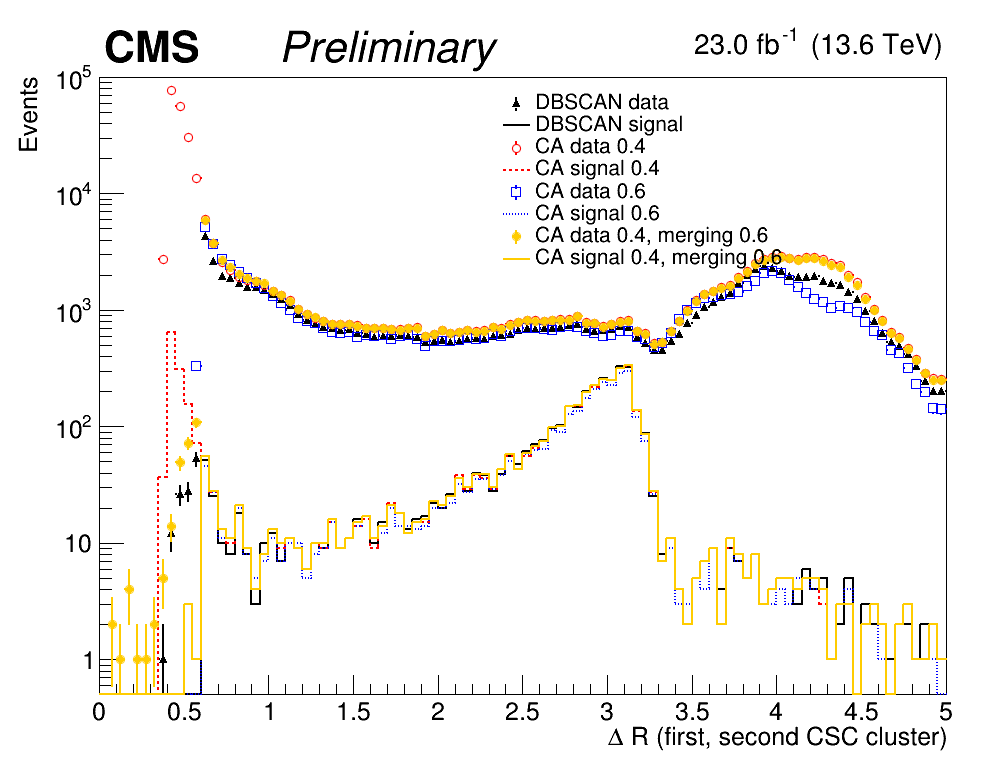

In [140]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.65,0.65,0.88)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()

nevents_passing = {}
for k in tree_keys:
    print(k)
    tmp_cscClusterSize = cscClusterSize[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) ]
    tmp_cscClusterEta = cscClusterEta[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) ]
    tmp_cscClusterPhi = cscClusterPhi[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) ]
    print( deltaR(tmp_cscClusterEta[:,0].flatten(), tmp_cscClusterPhi[:,0].flatten(), tmp_cscClusterEta[:,1].flatten(), tmp_cscClusterPhi[:,1].flatten()) )
    tmp_dR = deltaR(tmp_cscClusterEta[:,0].flatten(), tmp_cscClusterPhi[:,0].flatten(), tmp_cscClusterEta[:,1].flatten(), tmp_cscClusterPhi[:,1].flatten())
    #print( (p1 - p2 + np.pi) % (2 * np.pi) - np.pi )

    
    h1[k] = create_TH1D(tmp_dR,title="",axis_title = ['#Delta R (first, second CSC cluster)','Events'], binning=[100,0,5])
    leg.AddEntry(h1[k],data_label[k],'PE' if 'data' in k else 'L')
    h1[k].SetLineColor(colors[k])
    h1[k].SetLineWidth(2)
    h1[k].SetLineStyle(line_style[k])
    h1[k].SetMarkerColor(colors[k])
    h1[k].SetMarkerStyle(marker_style[k])
    h1[k].SetMarkerSize(1.2)
    #if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h1[k].SetMaximum(1.e05)

    nevents_passing[k] = event_cut[k][ np.logical_and(event_cut[k],nCscClusters[k]==2) ].sum()
    
leg.Draw()
can.SetRightMargin(0.05)

print("DBSCAN: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing['signalv4'], nevents_passing['datav4'], float(nevents_passing['signalv4'])/float(nevents_passing['datav4']), float(nevents_passing['signalv4'])/float(math.sqrt(nevents_passing['datav4'])) ) )
print("CA 0.6: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing['signalv6'], nevents_passing['datav6'], float(nevents_passing['signalv6'])/float(nevents_passing['datav6']), float(nevents_passing['signalv6'])/float(math.sqrt(nevents_passing['datav6'])) ) )
print("CA 0.4: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing['signalv5'], nevents_passing['datav5'], float(nevents_passing['signalv5'])/float(nevents_passing['datav5']), float(nevents_passing['signalv5'])/float(math.sqrt(nevents_passing['datav5'])) ) )
print("CA 0.4 merging 0.6: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing['signalv10'], nevents_passing['datav10'], float(nevents_passing['signalv10'])/float(nevents_passing['datav10']), float(nevents_passing['signalv10'])/float(math.sqrt(nevents_passing['datav10'])) ) )

# if setlog: 
can.SetLogy()
can.Draw()
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.Print("plots/V1p19_"+plot_folder+"/DeltaR_csc_clusters"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/DeltaR_csc_clusters"+plot_string+".png")
#can.Close()

### Delta R in different HLT categories

## Time plots

In [135]:
'''
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.6,0.8,1.0,1.0)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:
    
    #if 'data' in k: continue

    tmp_cscClusterTimeWeighted = cscClusterTimeWeighted[k][ event_cut[k] ]
    h0[k] = create_TH1D(tmp_cscClusterTimeWeighted[:,0].flatten(),title="",axis_title = ['Csc Cluster Time Weighted (ns)','Events'], binning=[300,-150,150])
    leg.AddEntry(h0[k],"First cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(1)
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(1)
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h0[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    tmp_cscClusterTimeWeighted = cscClusterTimeWeighted[k][ np.logical_and(event_cut[k],nCscClusters[k]>1) ]
    h1[k] = create_TH1D(tmp_cscClusterTimeWeighted[:,1].flatten(),title="",axis_title = ['Csc Cluster Time Weighted (ns)','Events'], binning=[300,-150,150])
    leg.AddEntry(h1[k],"Second cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h1[k].SetLineColor(2)
    h1[k].SetLineWidth(2)
    h1[k].SetLineStyle(line_style[k])
    h1[k].SetMarkerColor(2)
    h1[k].SetMarkerStyle(marker_style[k])
    h1[k].SetMarkerSize(1.2)
    if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    h1[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    
    #selection when more than 2...
    #h2[k] = create_TH1D(cscClusterSize3[k][:,2].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    #leg.AddEntry(h2[k],"Third cluster "+data_label[k],'PE' if 'data' in k else 'L')
    #h2[k].SetLineColor(4)
    #h2[k].SetLineWidth(2)
    #h2[k].SetLineStyle(line_style[k])
    #h2[k].SetMarkerColor(4)
    #h2[k].SetMarkerStyle(marker_style[k])
    #h2[k].SetMarkerSize(1.2)    
    #if h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())
    
    h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
    #h2[k].Draw('PE same')
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscClusterTimeWeighted"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscClusterTimeWeighted"+plot_string+".png")
'''

'\ncan = rt.TCanvas(\'c\',\'c\', 1000, 800)\nleg = rt.TLegend(0.6,0.8,1.0,1.0)\nleg.SetTextSize(0.03)\nleg.SetBorderSize(0)\nleg.SetEntrySeparation(0.01)\nh0 = {}\nh1 = {}\nh2 = {}\ncan.cd()\nfor k in tree_keys:\n    \n    #if \'data\' in k: continue\n\n    tmp_cscClusterTimeWeighted = cscClusterTimeWeighted[k][ event_cut[k] ]\n    h0[k] = create_TH1D(tmp_cscClusterTimeWeighted[:,0].flatten(),title="",axis_title = [\'Csc Cluster Time Weighted (ns)\',\'Events\'], binning=[300,-150,150])\n    leg.AddEntry(h0[k],"First cluster "+data_label[k],\'PE\' if \'data\' in k else \'L\')\n    h0[k].SetLineColor(1)\n    h0[k].SetLineWidth(2)\n    h0[k].SetLineStyle(line_style[k])\n    h0[k].SetMarkerColor(1)\n    h0[k].SetMarkerStyle(marker_style[k])\n    h0[k].SetMarkerSize(1.2)\n    if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())\n    h0[k].SetMaximum(1.5)\n    #h[k].SetMinimum(0.002)\n\n    tmp_cscClusterTimeWeighted = cscClusterTimeWeighted[k][ np.logical_and(event_cut[k],nCscClusters[k]>

In [136]:
'''
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.6,0.8,1.0,1.0)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:
    
    #if 'data' in k: continue

    tmp_cscClusterTimeWeighted = cscClusterTimeWeighted[k][ event_cut[k] ]
    h0[k] = create_TH1D(tmp_cscClusterTimeWeighted[:,0].flatten(),title="",axis_title = ['Csc Cluster Time Weighted (ns)','Events'], binning=[300,-150,150])
    leg.AddEntry(h0[k],"First cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(1)
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(1)
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h0[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    tmp_cscClusterTimeWeighted = cscClusterTimeWeighted[k][ np.logical_and(event_cut[k],nCscClusters[k]>1) ]
    h1[k] = create_TH1D(tmp_cscClusterTimeWeighted[:,1].flatten(),title="",axis_title = ['Csc Cluster Time Weighted (ns)','Events'], binning=[300,-150,150])
    #leg.AddEntry(h1[k],"Second cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h1[k].SetLineColor(2)
    h1[k].SetLineWidth(2)
    h1[k].SetLineStyle(line_style[k])
    h1[k].SetMarkerColor(2)
    h1[k].SetMarkerStyle(marker_style[k])
    h1[k].SetMarkerSize(1.2)
    if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    h1[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    
    #selection when more than 2...
    #h2[k] = create_TH1D(cscClusterSize3[k][:,2].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    #leg.AddEntry(h2[k],"Third cluster "+data_label[k],'PE' if 'data' in k else 'L')
    #h2[k].SetLineColor(4)
    #h2[k].SetLineWidth(2)
    #h2[k].SetLineStyle(line_style[k])
    #h2[k].SetMarkerColor(4)
    #h2[k].SetMarkerStyle(marker_style[k])
    #h2[k].SetMarkerSize(1.2)    
    #if h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())
    
    #h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
    #h2[k].Draw('PE same')
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterTimeWeighted"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterTimeWeighted"+plot_string+".png")
'''

'\ncan = rt.TCanvas(\'c\',\'c\', 1000, 800)\nleg = rt.TLegend(0.6,0.8,1.0,1.0)\nleg.SetTextSize(0.03)\nleg.SetBorderSize(0)\nleg.SetEntrySeparation(0.01)\nh0 = {}\nh1 = {}\nh2 = {}\ncan.cd()\nfor k in tree_keys:\n    \n    #if \'data\' in k: continue\n\n    tmp_cscClusterTimeWeighted = cscClusterTimeWeighted[k][ event_cut[k] ]\n    h0[k] = create_TH1D(tmp_cscClusterTimeWeighted[:,0].flatten(),title="",axis_title = [\'Csc Cluster Time Weighted (ns)\',\'Events\'], binning=[300,-150,150])\n    leg.AddEntry(h0[k],"First cluster "+data_label[k],\'PE\' if \'data\' in k else \'L\')\n    h0[k].SetLineColor(1)\n    h0[k].SetLineWidth(2)\n    h0[k].SetLineStyle(line_style[k])\n    h0[k].SetMarkerColor(1)\n    h0[k].SetMarkerStyle(marker_style[k])\n    h0[k].SetMarkerSize(1.2)\n    if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())\n    h0[k].SetMaximum(1.5)\n    #h[k].SetMinimum(0.002)\n\n    tmp_cscClusterTimeWeighted = cscClusterTimeWeighted[k][ np.logical_and(event_cut[k],nCscClusters[k]>

In [137]:
'''
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.6,0.8,1.0,1.0)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:
    
    #if 'data' in k: continue

    tmp_cscClusterTimeSpreadWeighted = cscClusterTimeSpreadWeighted[k][ event_cut[k] ]
    h0[k] = create_TH1D(tmp_cscClusterTimeSpreadWeighted[:,0].flatten(),title="",axis_title = ['Csc Cluster Time Spread Weighted (ns)','Events'], binning=[300,0,150])
    leg.AddEntry(h0[k],"First cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(1)
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(1)
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h0[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    tmp_cscClusterTimeSpreadWeighted = cscClusterTimeSpreadWeighted[k][ np.logical_and(event_cut[k],nCscClusters[k]>1) ]
    h1[k] = create_TH1D(tmp_cscClusterTimeSpreadWeighted[:,1].flatten(),title="",axis_title = ['Csc Cluster Time Weighted (ns)','Events'], binning=[300,0,150])
    #leg.AddEntry(h1[k],"Second cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h1[k].SetLineColor(2)
    h1[k].SetLineWidth(2)
    h1[k].SetLineStyle(line_style[k])
    h1[k].SetMarkerColor(2)
    h1[k].SetMarkerStyle(marker_style[k])
    h1[k].SetMarkerSize(1.2)
    if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    h1[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    
    #selection when more than 2...
    #h2[k] = create_TH1D(cscClusterSize3[k][:,2].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    #leg.AddEntry(h2[k],"Third cluster "+data_label[k],'PE' if 'data' in k else 'L')
    #h2[k].SetLineColor(4)
    #h2[k].SetLineWidth(2)
    #h2[k].SetLineStyle(line_style[k])
    #h2[k].SetMarkerColor(4)
    #h2[k].SetMarkerStyle(marker_style[k])
    #h2[k].SetMarkerSize(1.2)    
    #if h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())
    
    #h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
    #h2[k].Draw('PE same')
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterTimeSpreadWeighted"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterTimeSpreadWeighted"+plot_string+".png")
'''

'\ncan = rt.TCanvas(\'c\',\'c\', 1000, 800)\nleg = rt.TLegend(0.6,0.8,1.0,1.0)\nleg.SetTextSize(0.03)\nleg.SetBorderSize(0)\nleg.SetEntrySeparation(0.01)\nh0 = {}\nh1 = {}\nh2 = {}\ncan.cd()\nfor k in tree_keys:\n    \n    #if \'data\' in k: continue\n\n    tmp_cscClusterTimeSpreadWeighted = cscClusterTimeSpreadWeighted[k][ event_cut[k] ]\n    h0[k] = create_TH1D(tmp_cscClusterTimeSpreadWeighted[:,0].flatten(),title="",axis_title = [\'Csc Cluster Time Spread Weighted (ns)\',\'Events\'], binning=[300,0,150])\n    leg.AddEntry(h0[k],"First cluster "+data_label[k],\'PE\' if \'data\' in k else \'L\')\n    h0[k].SetLineColor(1)\n    h0[k].SetLineWidth(2)\n    h0[k].SetLineStyle(line_style[k])\n    h0[k].SetMarkerColor(1)\n    h0[k].SetMarkerStyle(marker_style[k])\n    h0[k].SetMarkerSize(1.2)\n    if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())\n    h0[k].SetMaximum(1.5)\n    #h[k].SetMinimum(0.002)\n\n    tmp_cscClusterTimeSpreadWeighted = cscClusterTimeSpreadWeighted[k][ np.logical

In [138]:
'''
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.6,0.8,1.0,1.0)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:
    
    #if 'data' in k: continue

    tmp_cscClusterTimeWeighted = cscClusterTimeWeighted[k][ event_cut[k] ]
    h0[k] = create_TH1D(tmp_cscClusterTimeWeighted[:,0].flatten(),title="",axis_title = ['Csc Cluster Time Weighted (ns)','Events'], binning=[300,-150,150])
    #leg.AddEntry(h0[k],"First cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(1)
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(1)
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h0[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    tmp_cscClusterTimeWeighted = cscClusterTimeWeighted[k][ np.logical_and(event_cut[k],nCscClusters[k]>1) ]
    h1[k] = create_TH1D(tmp_cscClusterTimeWeighted[:,1].flatten(),title="",axis_title = ['Csc Cluster Time Weighted (ns)','Events'], binning=[300,-150,150])
    leg.AddEntry(h1[k],"Second cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h1[k].SetLineColor(2)
    h1[k].SetLineWidth(2)
    h1[k].SetLineStyle(line_style[k])
    h1[k].SetMarkerColor(2)
    h1[k].SetMarkerStyle(marker_style[k])
    h1[k].SetMarkerSize(1.2)
    if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    h1[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    
    #selection when more than 2...
    #h2[k] = create_TH1D(cscClusterSize3[k][:,2].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    #leg.AddEntry(h2[k],"Third cluster "+data_label[k],'PE' if 'data' in k else 'L')
    #h2[k].SetLineColor(4)
    #h2[k].SetLineWidth(2)
    #h2[k].SetLineStyle(line_style[k])
    #h2[k].SetMarkerColor(4)
    #h2[k].SetMarkerStyle(marker_style[k])
    #h2[k].SetMarkerSize(1.2)    
    #if h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())
    
    h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
    #h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
    #h2[k].Draw('PE same')
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/"+plot_folder+"CscSecondClusterTimeWeighted"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscSecondClusterTimeWeighted"+plot_string+".png")
'''

'\ncan = rt.TCanvas(\'c\',\'c\', 1000, 800)\nleg = rt.TLegend(0.6,0.8,1.0,1.0)\nleg.SetTextSize(0.03)\nleg.SetBorderSize(0)\nleg.SetEntrySeparation(0.01)\nh0 = {}\nh1 = {}\nh2 = {}\ncan.cd()\nfor k in tree_keys:\n    \n    #if \'data\' in k: continue\n\n    tmp_cscClusterTimeWeighted = cscClusterTimeWeighted[k][ event_cut[k] ]\n    h0[k] = create_TH1D(tmp_cscClusterTimeWeighted[:,0].flatten(),title="",axis_title = [\'Csc Cluster Time Weighted (ns)\',\'Events\'], binning=[300,-150,150])\n    #leg.AddEntry(h0[k],"First cluster "+data_label[k],\'PE\' if \'data\' in k else \'L\')\n    h0[k].SetLineColor(1)\n    h0[k].SetLineWidth(2)\n    h0[k].SetLineStyle(line_style[k])\n    h0[k].SetMarkerColor(1)\n    h0[k].SetMarkerStyle(marker_style[k])\n    h0[k].SetMarkerSize(1.2)\n    if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())\n    h0[k].SetMaximum(1.5)\n    #h[k].SetMinimum(0.002)\n\n    tmp_cscClusterTimeWeighted = cscClusterTimeWeighted[k][ np.logical_and(event_cut[k],nCscClusters[k]

In [139]:
'''
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.6,0.8,1.0,1.0)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:
    
    #if 'data' in k: continue

    tmp_cscClusterTimeSpreadWeighted = cscClusterTimeSpreadWeighted[k][ event_cut[k] ]
    h0[k] = create_TH1D(tmp_cscClusterTimeSpreadWeighted[:,0].flatten(),title="",axis_title = ['Csc Cluster Time Spread Weighted (ns)','Events'], binning=[300,0,150])
    #leg.AddEntry(h0[k],"First cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(1)
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(1)
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    h0[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    tmp_cscClusterTimeSpreadWeighted = cscClusterTimeSpreadWeighted[k][ np.logical_and(event_cut[k],nCscClusters[k]>1) ]
    h1[k] = create_TH1D(tmp_cscClusterTimeSpreadWeighted[:,1].flatten(),title="",axis_title = ['Csc Cluster Time Weighted (ns)','Events'], binning=[300,0,150])
    leg.AddEntry(h1[k],"Second cluster "+data_label[k],'PE' if 'data' in k else 'L')
    h1[k].SetLineColor(2)
    h1[k].SetLineWidth(2)
    h1[k].SetLineStyle(line_style[k])
    h1[k].SetMarkerColor(2)
    h1[k].SetMarkerStyle(marker_style[k])
    h1[k].SetMarkerSize(1.2)
    if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    h1[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    
    #selection when more than 2...
    #h2[k] = create_TH1D(cscClusterSize3[k][:,2].flatten(),title="",axis_title = ['Csc Cluster Size','Events'], binning=[100,0,1000])
    #leg.AddEntry(h2[k],"Third cluster "+data_label[k],'PE' if 'data' in k else 'L')
    #h2[k].SetLineColor(4)
    #h2[k].SetLineWidth(2)
    #h2[k].SetLineStyle(line_style[k])
    #h2[k].SetMarkerColor(4)
    #h2[k].SetMarkerStyle(marker_style[k])
    #h2[k].SetMarkerSize(1.2)    
    #if h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())
    
    h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
    #h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    
    #h2[k].Draw('PE same')
    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscSecondClusterTimeSpreadWeighted"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscSecondClusterTimeSpreadWeighted"+plot_string+".png")
'''

'\ncan = rt.TCanvas(\'c\',\'c\', 1000, 800)\nleg = rt.TLegend(0.6,0.8,1.0,1.0)\nleg.SetTextSize(0.03)\nleg.SetBorderSize(0)\nleg.SetEntrySeparation(0.01)\nh0 = {}\nh1 = {}\nh2 = {}\ncan.cd()\nfor k in tree_keys:\n    \n    #if \'data\' in k: continue\n\n    tmp_cscClusterTimeSpreadWeighted = cscClusterTimeSpreadWeighted[k][ event_cut[k] ]\n    h0[k] = create_TH1D(tmp_cscClusterTimeSpreadWeighted[:,0].flatten(),title="",axis_title = [\'Csc Cluster Time Spread Weighted (ns)\',\'Events\'], binning=[300,0,150])\n    #leg.AddEntry(h0[k],"First cluster "+data_label[k],\'PE\' if \'data\' in k else \'L\')\n    h0[k].SetLineColor(1)\n    h0[k].SetLineWidth(2)\n    h0[k].SetLineStyle(line_style[k])\n    h0[k].SetMarkerColor(1)\n    h0[k].SetMarkerStyle(marker_style[k])\n    h0[k].SetMarkerSize(1.2)\n    if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())\n    h0[k].SetMaximum(1.5)\n    #h[k].SetMinimum(0.002)\n\n    tmp_cscClusterTimeSpreadWeighted = cscClusterTimeSpreadWeighted[k][ np.logica

# Todo list

* Look at different endcaps in the plot for csc time and n station
* Look at clusters associated with a muon, do they have the double peak?
* Look at clusters associated with a jet, double peak?
* Does the time spread cut remove the second peak?
* Study v4
* Study v5 --> some small amount of events with less than 50 hits in dbscan
* Study what happens with L1 and HLT conditions and more than 1 CSC cluster
* Study DT turn on